In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ModuleNotFoundError: No module named 'pandas_profiling'

In [ ]:
#the csv file is sometimes not well separated when there is more than one author, have to correct it manualy
df = pd.read_csv("C:/Users/Ben/GoodReadsProject/books.csv",sep=",",index_col="bookID")

In [ ]:
#First look at all the variables
print(list(df))
#There is a space in some column name
# remove special character
df.columns = df.columns.str.replace(' ', '')
list(df)

In [2]:
#Droping the 2 uniaue identifiers, we won't have use of them
df = df.drop(columns=["isbn","isbn13"]) 

NameError: name 'df' is not defined

In [ ]:
#Note : After trying a linear regression we will change our approach to a classification. 
#We have a problem at the start wich are the data by themself. most of the average rating are very concentrated around the mean. 
#therefore we don't have enough lower ratings.The model can't be good at predicting bad ratings. 
#We are going to regroup ratings in 3 category : bad / medium / good 
#We will base the bining o the distribution of the series

In [6]:
#Here are all the transformation on the dataset based on my analysys below  

#Droping the rows with ratings_count < 100, so we only keep trustable average rating result to train our model
#Careful we need calculate the sum of rating count per book and then applied this filter on the sum of rating counts
df.drop(df[df['ratings_count'] < 100].index, inplace = True)

#Droping the rows with languages underbalanced


#Droping the 2 uniaue identifiers, we won't have use of them
df = df.drop(columns=["isbn","isbn13"]) 

#There is a space in some column name
# remove special character
df.columns = df.columns.str.replace(' ', '')

#We are going to round average rating to one decimal, we don't need a high precision, 
#we actually want to know if this book is going to be bad, average, good or very good. Let's see how we can split the model
df.round({'average_rating': 1})

#multiply average rating by 5 to spread the value and have a better visual understanding of the data
df['average_rating'] = df['average_rating'].apply(lambda x: x*4)


KeyError: "['isbn', 'isbn13'] not found in axis"

In [29]:
df.describe()
#We see that num pages ratings and text review are float variable, this is not possible, we will force those variable into int

average_rating        isbn13     num_pages  ratings_count  \
count    11127.000000  1.112700e+04  11127.000000   1.112700e+04   
mean         3.933631  9.759888e+12    336.376921   1.793641e+04   
std          0.352445  4.428964e+11    241.127305   1.124794e+05   
min          0.000000  8.987060e+09      0.000000   0.000000e+00   
25%          3.770000  9.780350e+12    192.000000   1.040000e+02   
50%          3.960000  9.780590e+12    299.000000   7.450000e+02   
75%          4.135000  9.780870e+12    416.000000   4.993500e+03   
max          5.000000  9.790010e+12   6576.000000   4.597666e+06   

       text_reviews_count  
count        11127.000000  
mean           541.854498  
std           2576.176608  
min              0.000000  
25%              9.000000  
50%             46.000000  
75%            237.500000  
max          94265.000000

In [30]:
df.describe()
df.dtypes

title                   object
authors                 object
average_rating         float64
language_code           object
num_pages                int64
ratings_count            int64
text_reviews_count       int64
publication_date        object
publisher               object
num_pages1               int32
ratings_count1           int32
text_reviews_count1      int32
dtype: object

In [182]:
# Generate the profile report with Pandas Profiling
profile = ProfileReport(
    df,
    title="summarization of data"
)

In [183]:
# Generate the dataset profile
# This is a nice and simple way to document the data
profile.to_notebook_iframe()

#All the quant variable have a relatively low correlation with average rating.
#Text review and rating counts are strongly correlated together (multicolinearity, I will keep only one of this 2 column)
#Average ratings is normaly distributed around 3.93. We can see outliers around 0. furthermore the big majority of the 
#distribution is beetween 3 and 4.5. 
#We can see there is a # in the title for books in a series ie : Harry Potter 
#Some books have a small numbers of rating, we will choose to drop those row because it is hard to trust those ratings 
#We see the title is not a unique identifier, we will look further into this
#For the publication date, we will keep only the year and see if there is any pattern inside the data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

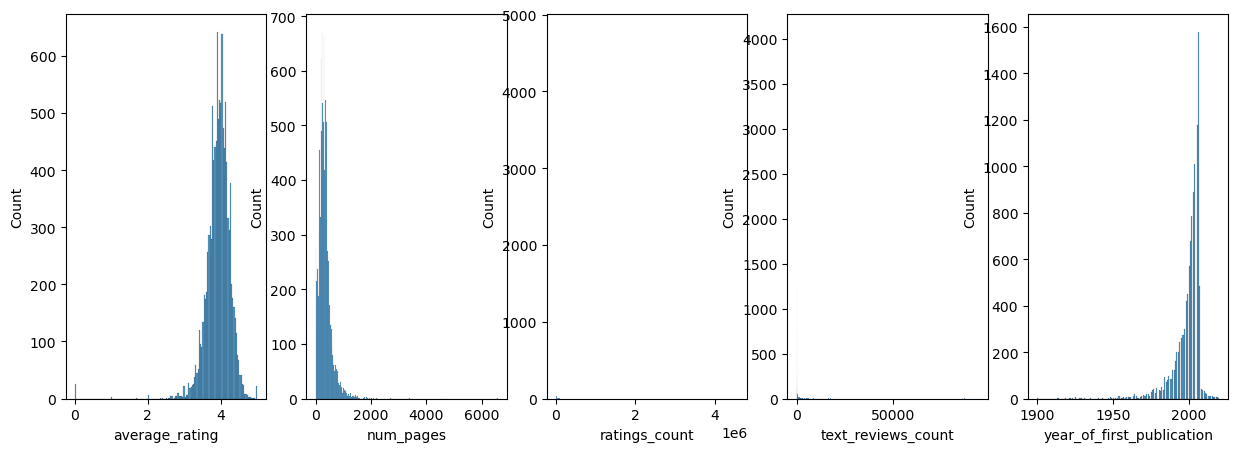

In [6]:
#lets look at the distribution of our numerical variables
#We gonna first extract the year of publication from the date and transform it as a int variable and visualy look at all the distribution


#Year of first publication :

#first we  extract the year from the column date and convert it to int
df['year'] = df['publication_date'].str.slice(start=-4)
df['year'] = df['year'].astype(int)

#Some books appear several times with different publication data so will keep the year of first publication per book
df['year_of_first_publication'] = df.groupby('title')['year'].transform('min')
df['year_of_first_publication'] = df['year_of_first_publication'].astype(int)


# Select columns to plot
columns_to_plot = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'year_of_first_publication']

# Create a figure with subplots
fig, axs = plt.subplots(ncols=len(columns_to_plot), figsize=(15, 5))

# Loop through each column to plot and create a histogram plot
for i, col in enumerate(columns_to_plot):
    sns.histplot(data=df, x=col, ax=axs[i])

# Display the plot
plt.show()

#note : 
#The ratings distribution is normal and higly centered around 3.9. Only a relatively low numbers books have a rating under 3/2
#It is going to be a problem for our model to detect "bad" books. 
#A good distribution would have been centered around 2.5 a normaly distributed
#hard to say anything to ratings count and text review count so far except that the distribution goes around a large number of values
#The Year and num_pages look normally distributed and skewed respectively to the left and to the right.
#We do note a lot of 0 value for ratings count, text review count and num_pages

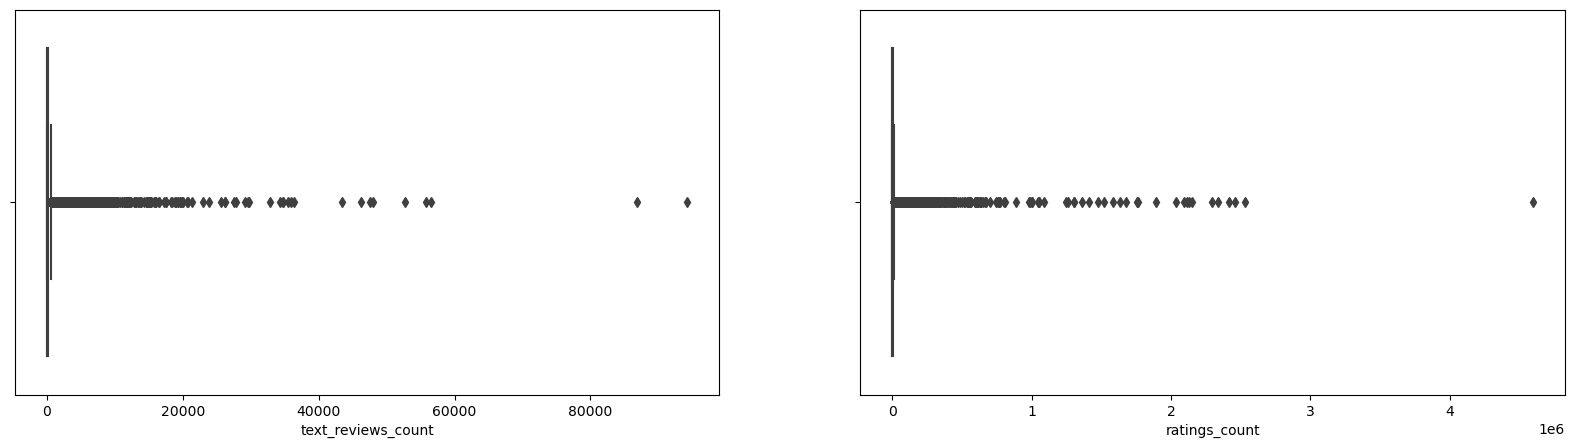

text_reviews_count  ratings_count
count        11127.000000   1.112700e+04
mean           541.854498   1.793641e+04
std           2576.176608   1.124794e+05
min              0.000000   0.000000e+00
25%              9.000000   1.040000e+02
50%             46.000000   7.450000e+02
75%            237.500000   4.993500e+03
max          94265.000000   4.597666e+06

In [40]:
#Look closer into counts variables

# Create a figure with subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

# Select the variables to plot
vars_to_plot = ['text_reviews_count','ratings_count']

# Loop through each variable and create a boxplot
for i, var in enumerate(vars_to_plot):
    sns.boxplot(data=df, x=var, ax=axs[i])

# Display the plot
plt.show()


count_df = df[['text_reviews_count','ratings_count']]
count_df.describe()

#We clearly see outliers, also lot of books haven't been rated lot of times. we should get rid of them.


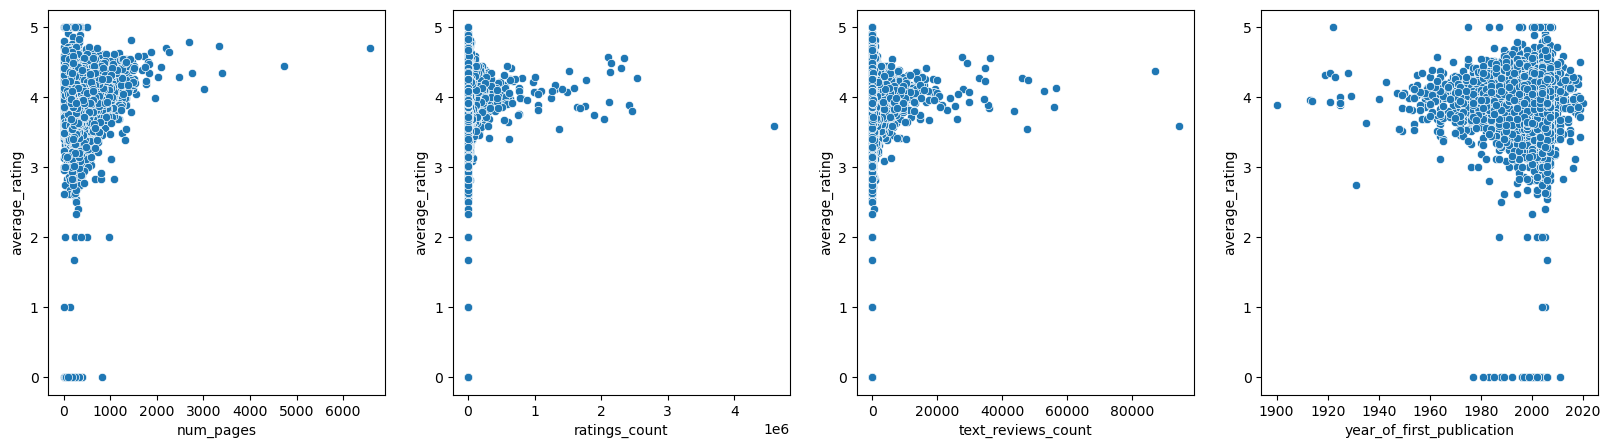

In [41]:
#Let's look at the relation between the target and the explanatory variables 

# Create a figure with subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

# Select the target variable
target_var = 'average_rating'

# Select the explanatory variables
explanatory_vars = ['num_pages', 'ratings_count', 'text_reviews_count', 'year_of_first_publication']

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=df, x=var, y=target_var, ax=axs[i])

# Display the plot
plt.show()

#We have a problem, we have a lot of problematic value around 0.
#ie: ratings count, it seems like lot of books have a low number of ratings and past an amount of ratings the  
#avg rating becomes a lot more concentrated.
# It is tricky because on one side, can we trust the avg rating for a low number of rating, and on the other side, there is a
#high chance that the book will be well rated if it is a famous one. 

       average_rating    num_pages  ratings_count  text_reviews_count  \
count     2734.000000  2734.000000    2734.000000         2734.000000   
mean         3.868939   292.013168      34.863570            3.769934   
std          0.532129   240.991686      28.491248            4.216007   
min          0.000000     0.000000       0.000000            0.000000   
25%          3.700000   139.250000      10.000000            1.000000   
50%          3.925000   248.000000      28.000000            2.000000   
75%          4.130000   384.000000      57.000000            6.000000   
max          5.000000  3400.000000     100.000000           37.000000   

              year  year_of_first_publication  PublisherOccur  average_rating  \
count  2734.000000                2734.000000     2734.000000     8393.000000   
mean   1998.944770                1998.441112       20.203365        3.954704   
std       9.643303                  10.008595       36.068566        0.265823   
min    1914.000000

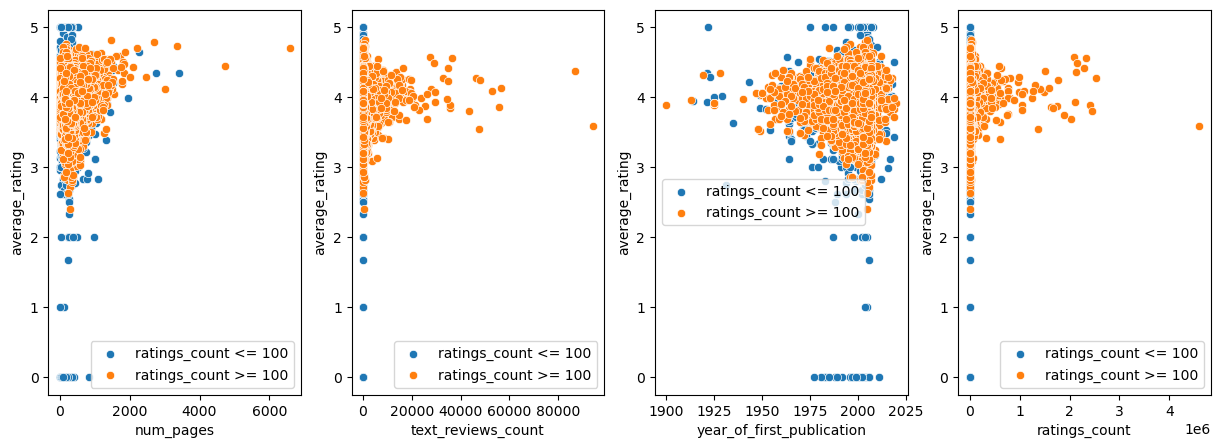

In [22]:
threshold = 100
# Select rows where 'ratings_count' is less than or equal to 100
lowrc_df = df.loc[df['ratings_count'] <= threshold]

# Select rows where 'ratings_count' is greater than 100
high_df = df.loc[df['ratings_count'] > threshold]

# Get the summary statistics for each dataframe
lowrc_summary = lowrc_df.describe()
high_summary = high_df.describe()

# Concatenate the summary statistics horizontally
summary_concat = pd.concat([lowrc_summary, high_summary], axis=1)

# Display the concatenated summary statistics
print(summary_concat)


# Select the target variable
target_var = 'average_rating'

# Select the explanatory variables
explanatory_vars = ['num_pages', 'text_reviews_count', 'year_of_first_publication', 'ratings_count']

# Create a figure with subplots
fig, axs = plt.subplots(ncols=len(explanatory_vars), figsize=(15, 5))

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=lowrc_df, x=var, y=target_var, ax=axs[i], label=f'ratings_count <= {threshold}')
    sns.scatterplot(data=high_df, x=var, y=target_var, ax=axs[i], label=f'ratings_count >= {threshold}')
    #sns.scatterplot(data=df, x=var, y=target_var, ax=axs[i], label=f'ratings_count >= 0')
    axs[i].legend()

# Display the plot
plt.show()


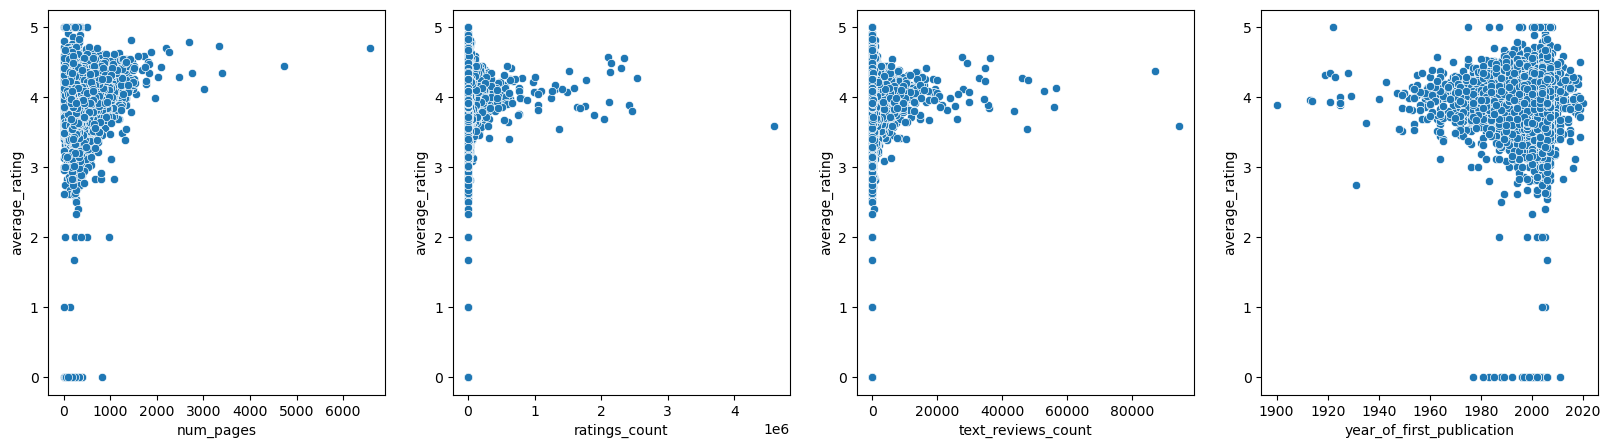

In [9]:
#Let's look at the relation between the target and the explanatory variables 

# Create a figure with subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

# Select the target variable
target_var = 'average_rating'

# Select the explanatory variables
explanatory_vars = ['num_pages', 'ratings_count', 'text_reviews_count', 'year_of_first_publication']

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=df, x=var, y=target_var, ax=axs[i])

# Display the plot
plt.show()


In [13]:
BadBooks = df.loc[(df['average_rating'] <=2.6) & (df['average_rating'] > 0)]
BadBooks.describe()
#Those data are very unreliable, most of them have only one rating

average_rating   num_pages  ratings_count  text_reviews_count  \
count       13.000000   13.000000      13.000000           13.000000   
mean         1.957692  295.384615     420.615385           45.307692   
std          0.492192  240.594589    1500.651000          159.765132   
min          1.000000    8.000000       0.000000            0.000000   
25%          2.000000  227.000000       1.000000            0.000000   
50%          2.000000  256.000000       2.000000            0.000000   
75%          2.330000  305.000000       3.000000            1.000000   
max          2.550000  972.000000    5415.000000          577.000000   

              year  year_of_first_publication  
count    13.000000                  13.000000  
mean   2001.000000                2001.000000  
std       6.429101                   6.429101  
min    1987.000000                1987.000000  
25%    2000.000000                2000.000000  
50%    2004.000000                2004.000000  
75%    2005.000000                2005.000000  
max    2006.000000                2006.000000

In [17]:
df['PublisherOccur'] = df.groupby('publisher')['publisher'].transform('size')
df.describe()

average_rating     num_pages  ratings_count  text_reviews_count  \
count    11127.000000  11127.000000   1.112700e+04        11127.000000   
mean         3.933631    336.376921   1.793641e+04          541.854498   
std          0.352445    241.127305   1.124794e+05         2576.176608   
min          0.000000      0.000000   0.000000e+00            0.000000   
25%          3.770000    192.000000   1.040000e+02            9.000000   
50%          3.960000    299.000000   7.450000e+02           46.000000   
75%          4.135000    416.000000   4.993500e+03          237.500000   
max          5.000000   6576.000000   4.597666e+06        94265.000000   

               year  year_of_first_publication  PublisherOccur  
count  11127.000000               11127.000000    11127.000000  
mean    2000.167520                1999.545160       46.889099  
std        8.248836                   8.888159       70.043878  
min     1900.000000                1900.000000        1.000000  
25%     1998.000000                1997.000000        5.000000  
50%     2003.000000                2002.000000       20.000000  
75%     2005.000000                2005.000000       56.000000  
max     2020.000000                2020.000000      318.000000

       average_rating    num_pages  ratings_count  text_reviews_count  \
count     2734.000000  2734.000000    2734.000000         2734.000000   
mean         3.868939   292.013168      34.863570            3.769934   
std          0.532129   240.991686      28.491248            4.216007   
min          0.000000     0.000000       0.000000            0.000000   
25%          3.700000   139.250000      10.000000            1.000000   
50%          3.925000   248.000000      28.000000            2.000000   
75%          4.130000   384.000000      57.000000            6.000000   
max          5.000000  3400.000000     100.000000           37.000000   

              year  year_of_first_publication  PublisherOccur  average_rating  \
count  2734.000000                2734.000000     2734.000000     8393.000000   
mean   1998.944770                1998.441112       20.203365        3.954704   
std       9.643303                  10.008595       36.068566        0.265823   
min    1914.000000

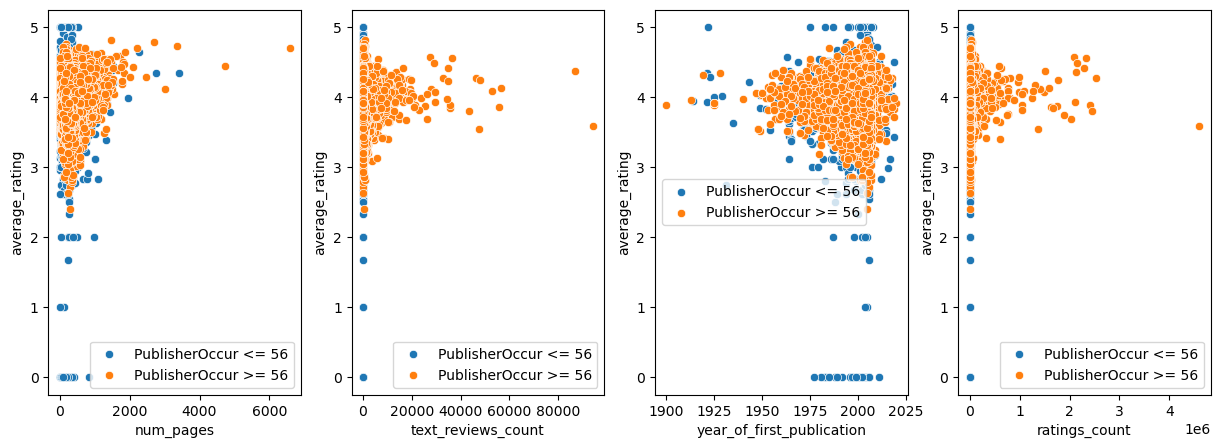

In [25]:
threshold = 56
# Select rows where 'ratings_count' is less than or equal to 100
lowpb_df = df.loc[df['PublisherOccur'] <= threshold]

# Select rows where 'ratings_count' is greater than 100
highpb_df = df.loc[df['PublisherOccur'] > threshold]

# Get the summary statistics for each dataframe
lowrc_summary = lowrc_df.describe()
high_summary = high_df.describe()

# Concatenate the summary statistics horizontally
summary_concat = pd.concat([lowrc_summary, high_summary], axis=1)

# Display the concatenated summary statistics
print(summary_concat)


# Select the target variable
target_var = 'average_rating'

# Select the explanatory variables
explanatory_vars = ['num_pages', 'text_reviews_count', 'year_of_first_publication', 'ratings_count']

# Create a figure with subplots
fig, axs = plt.subplots(ncols=len(explanatory_vars), figsize=(15, 5))

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=lowrc_df, x=var, y=target_var, ax=axs[i], label=f'PublisherOccur <= {threshold}')
    sns.scatterplot(data=high_df, x=var, y=target_var, ax=axs[i], label=f'PublisherOccur >= {threshold}')
    axs[i].legend()

# Display the plot
plt.show()


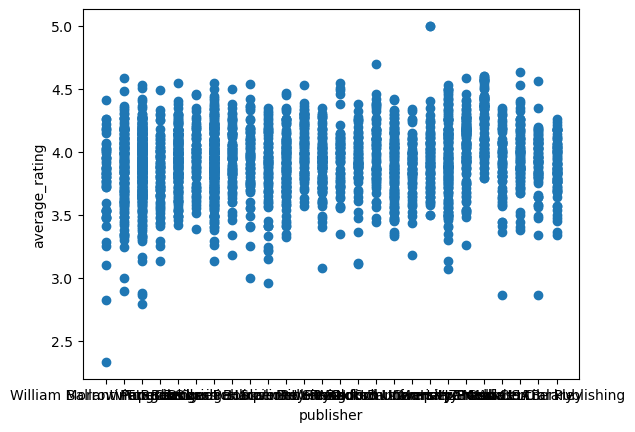

In [26]:
fig, ax = plt.subplots()
ax.scatter(highpb_df['publisher'], highpb_df['average_rating'])
ax.set_xlabel('publisher')
ax.set_ylabel('average_rating')
plt.show()

In [16]:
df.head(10) 

title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
9       Unauthorized Harry Potter Book Seven News: "Ha...   
10           Harry Potter Collection (Harry Potter  #1-6)   
12      The Ultimate Hitchhiker's Guide: Five Complete...   
13      The Ultimate Hitchhiker's Guide to the Galaxy ...   
14      The Hitchhiker's Guide to the Galaxy (Hitchhik...   

                           authors  average_rating language_code  num_pages  \
bookID                                                                        
1       J.K. Rowling/Mary GrandPré            4.57           eng        652   
2       J.K. Rowling/Mary GrandPré            4.49           eng        870   
4                     J.K. Rowling            4.42           eng        352   
5       J.K. Rowling/Mary GrandPré            4.56           eng        435   
8       J.K. Rowling/Mary GrandPré            4.78           eng       2690   
9           W. Frederick Zimmerman            3.74         en-US        152   
10                    J.K. Rowling            4.73           eng       3342   
12                   Douglas Adams            4.38           eng        815   
13                   Douglas Adams            4.38           eng        815   
14                   Douglas Adams            4.22           eng        215   

        ratings_count  text_reviews_count publication_date        publisher  \
bookID                                                                        
1             2095690               27591        9/16/2006  Scholastic Inc.   
2             2153167               29221        9/01/2004  Scholastic Inc.   
4                6333                 244       11/01/2003       Scholastic   
5             2339585               36325        5/01/2004  Scholastic Inc.   
8               41428                 164        9/13/2004       Scholastic   
9                  19                   1        4/26/2005     Nimble Books   
10              28242                 808        9/12/2005       Scholastic   
12               3628                 254       11/01/2005   Gramercy Books   
13             249558                4080        4/30/2002    Del Rey Books   
14               4930                 460        8/03/2004            Crown   

        year  year_of_first_publication  PublisherOccur  
bookID                                                   
1       2006                       2006              13  
2       2004                       2004              13  
4       2003                       1999              33  
5       2004                       2004              13  
8       2004                       2004              33  
9       2005                       2005               1  
10      2005                       2005              33  
12      2005                       2005              13  
13      2002                       2002              33  
14      2004                       1991               7

In [9]:
df.nunique() #look if bookID is unique --> YES It IS I can drop isbn and isbn13 for now

title                 10352
authors                6643
average_rating          209
isbn                  11127
isbn13                  239
language_code            27
num_pages               997
ratings_count          5294
text_reviews_count     1822
publication_date       3679
publisher              2292
Occur_authors             0
dtype: int64

In [5]:
df.describe(include = ['O']) # We can see that the title isn't a unique value and that some authors have written more than one book 
#but be carefull because python look for exactly the same value, there could be misspellings and errors. There's also more than one authors sometimes
#Also some authors have written several books; we should look if the number of book written by an authors 
#Could have an impact on the average ratings of those books. 

#Analysis : 

# 1) look into the books with the same name if there is a pattern or something odd
#--> We note that for a same title the ratings are averaged but the explanatory variables are different,
#compute the mean per title of num pages, average rating, total ratings count and min of date.
#1bis) Look if there is any pattern with name of the books (number of words ect..)
#2) Look into the average rating per language code
#2) find a way to look if the number of books written by an authors is correlated with the average rating of his books 
#3) find a way to signal if the book has been written by more than one authors (if there is a "/" in the string )
#and Look if co written book are rated differently
#4) Look if an authors has an already good book and see if it has an impact on the overall, maybe use a dummy to separate good
#authors from bad one
#5) Look into the rating/review count
#--> We only keep data we at leat 100 review (First quartile) to train our model on data we can trust. 
#6) Explore the publication date series


title         authors       isbn language_code  \
count                    11127           11127      11127         11127   
unique                   10352            6643      11127            27   
top     The Brothers Karamazov  P.G. Wodehouse  571161154           eng   
freq                         9              40          1          8911   

       publication_date publisher  
count             11127     11127  
unique             3679      2292  
top          10/01/2005   Vintage  
freq                 56       318

In [212]:
#1)look into the books with the same name if there is a pattern or something odd
#we look first with The Brothers Karamazov, there is 9 occurences
TheBrothersKaramazovBooks = df.loc[df['title'] == 'The Brothers Karamazov']
TheBrothersKaramazovBooks
#Seems all the books have exactly the same rating but different authors/num of page and ratings + review .. Should I drop those data ?

#Let's look at the dataset of non unique title

NonUnicTitle = df[df.duplicated(subset=['title'],keep=False)]
NonUnicTitle.sort_values(by='title', ascending=False) 

#When there's more than one row for a book title, it looks like the books has been republished with a different publisher 
#or under a different version.
#The rating has been averaged in most case (the rating is the same for all the rows with the same title). 
#In Salem's lot it's not the case, we need to average the rating per title and ponderate this mean per rating count of the version.
#Lets look at the basic stats of the data set

#NonUnicTitle.describe()
#At first sight, we don't see any impact on the overall average rating, only the std is smaller 
#The republished books migth be more concentrated around the mean
#Let's check books and there occurances, maybe if a book is published a lots of times the average ratings gonna raise




title                         authors  \
bookID                                                                         
12703                      Wuthering Heights      Emily Brontë/Alice Hoffman   
6184                       Wuthering Heights                    Emily Brontë   
9763    Wild Swans: Three Daughters of China                      Jung Chang   
1848    Wild Swans: Three Daughters of China                      Jung Chang   
44595                      Wide Sargasso Sea                       Jean Rhys   
...                                      ...                             ...   
19135                           'Salem's Lot        Stephen King/Ron McLarty   
5419                            'Salem's Lot                    Stephen King   
5415                            'Salem's Lot                    Stephen King   
5414                            'Salem's Lot        Stephen King/Ron McLarty   
5413                            'Salem's Lot  Stephen King/Jerry N. Uelsmann   

        average_rating language_code  num_pages  ratings_count  \
bookID                                                           
12703             3.85           eng        322           1898   
6184              3.85           eng        279           2155   
9763              4.26           eng        666           1832   
1848              4.26           eng        562          73572   
44595             3.58         en-US        168            878   
...                ...           ...        ...            ...   
19135             4.02         en-US          0             56   
5419              4.02         en-US        427            178   
5415              4.02           eng        405           1039   
5414              4.02           eng         17            227   
5413              4.25           eng        594          84123   

        text_reviews_count publication_date               publisher  
bookID                                                               
12703                  201        3/02/2004         Signet Classics  
6184                   182        1/13/2007           Penguin Books  
9763                   214        4/05/2004        Harper Perennial  
1848                  4280        8/12/2003         Simon  Schuster  
44595                   79        4/26/2001        Penguin Classics  
...                    ...              ...                     ...  
19135                    5        1/19/2004  Simon & Schuster Audio  
5419                    35       11/13/1979                  Signet  
5415                   130       10/17/1975               Doubleday  
5414                    54        1/19/2004  Simon & Schuster Audio  
5413                   571       11/01/2005               Doubleday  

[1262 rows x 9 columns]

C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\2599273839.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  rating = df.average_rating[:20]


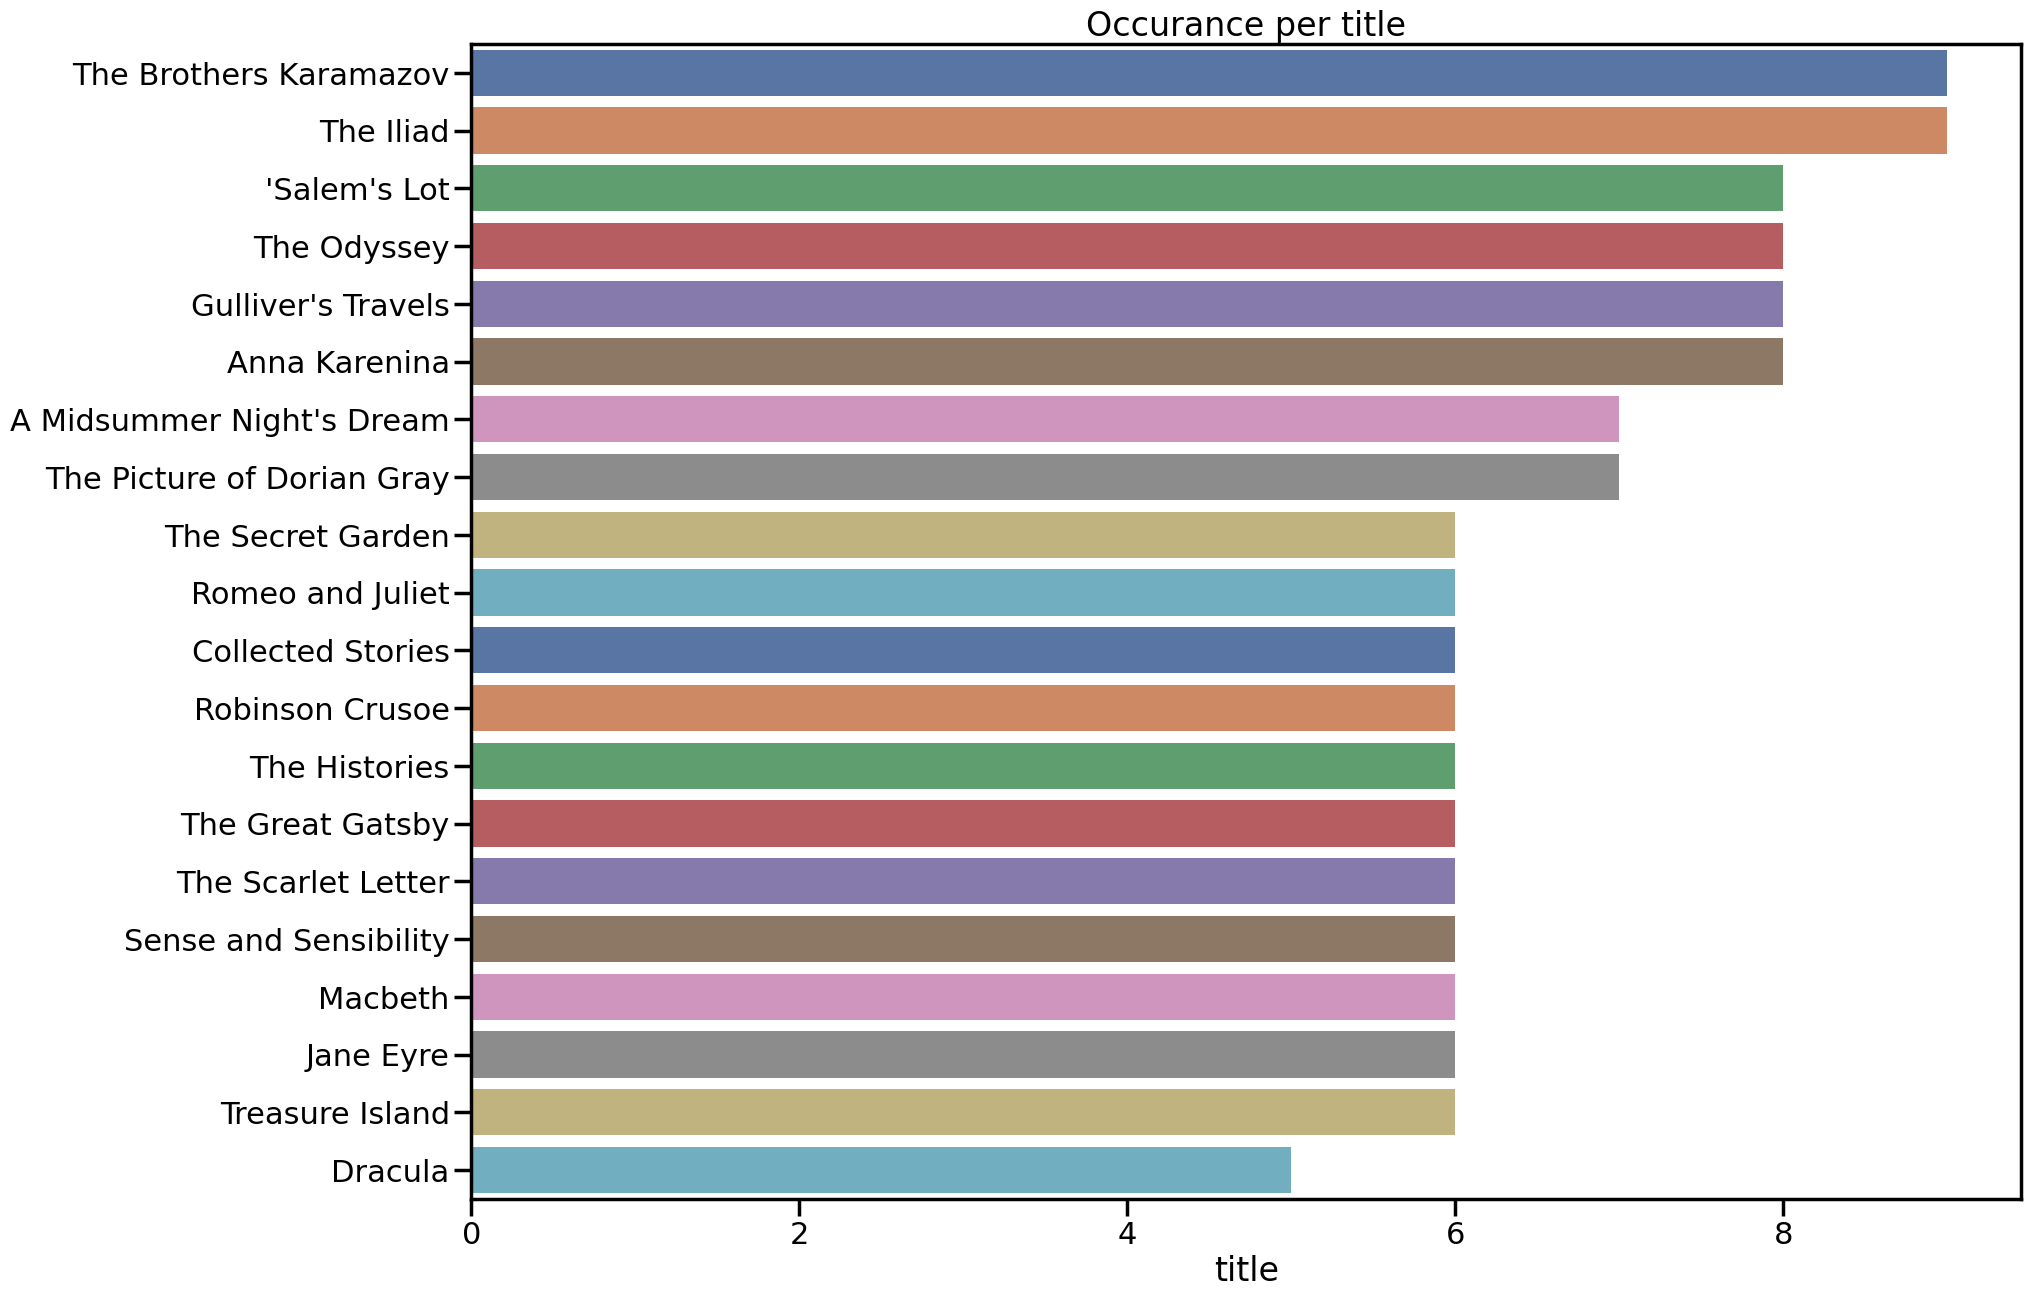

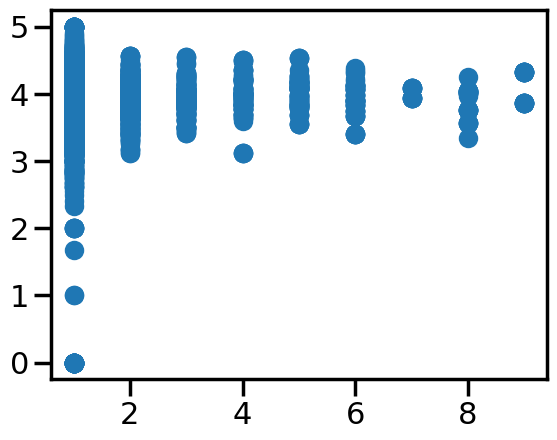

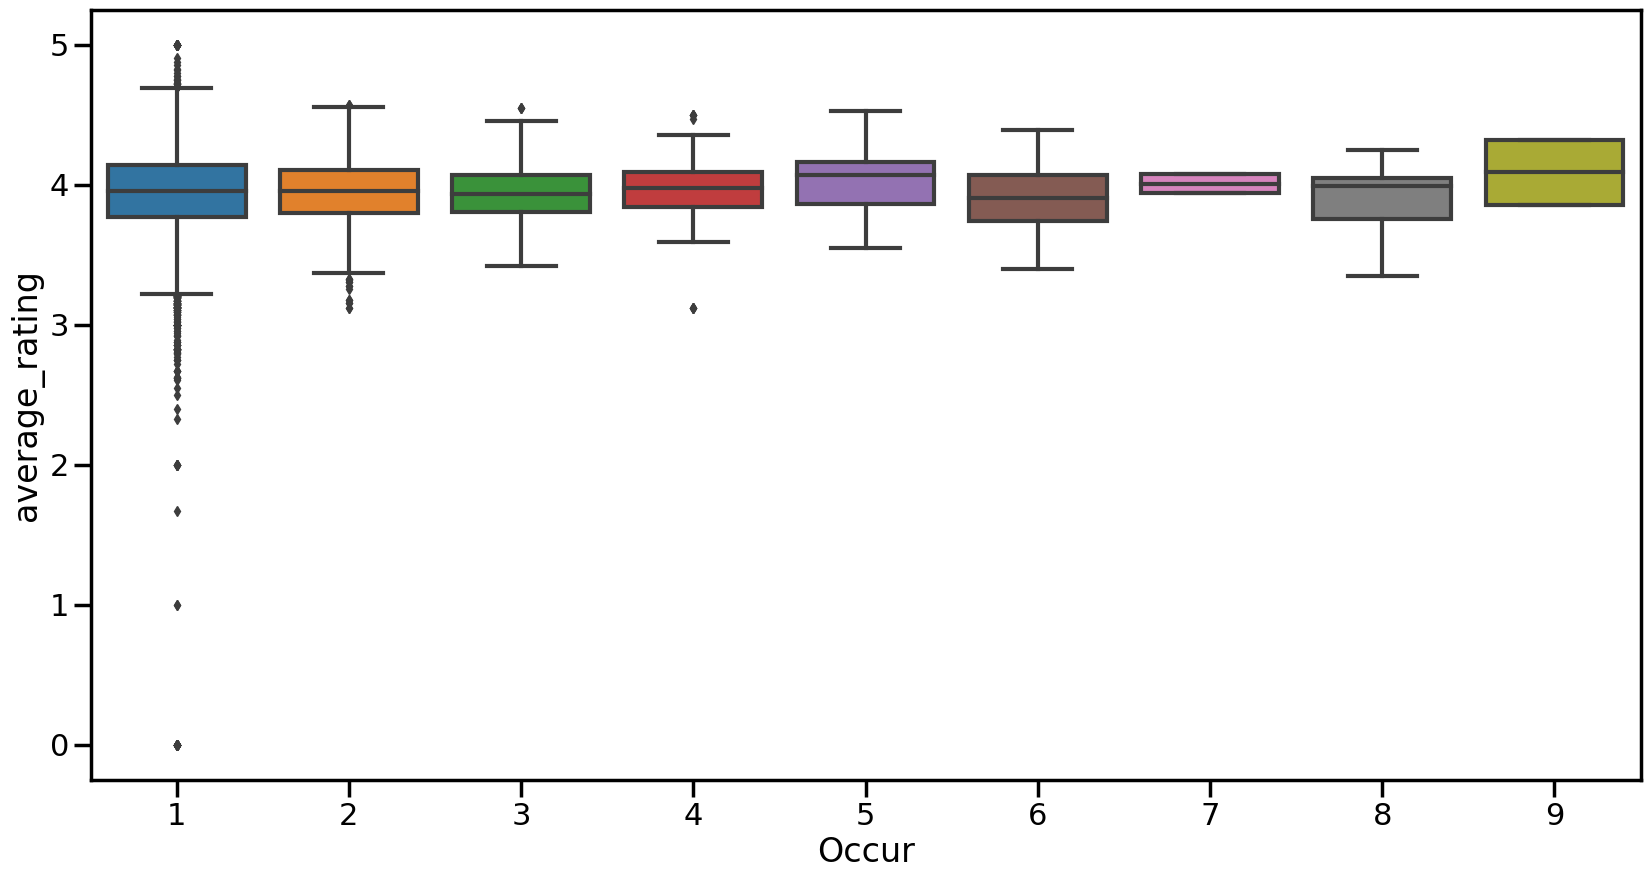

Average Ratings by Occur:
 Occur
9    4.090000
5    4.017200
7    4.010000
4    3.969839
2    3.940481
1    3.931882
3    3.931441
6    3.911970
8    3.862812
Name: average_rating, dtype: float64


1    9865
2     686
3     222
4     124
5     100
6      66
8      32
9      18
7      14
Name: Occur, dtype: int64

In [213]:
#Here the 20 first books per occurence count
sns.set_context('poster')
plt.figure(figsize=(20,15))
book = df['title'].value_counts()[:20]
rating = df.average_rating[:20]
sns.barplot(x=book, y=book.index, palette= 'deep').set(title='Occurance per title')
plt.show()

#Lets look if higher the occurances, higher the rating, I will add the column "Occur"to the dataset 
df['Occur'] = df.groupby('title')['title'].transform('size')

plt.scatter(df["Occur"],df["average_rating"])

#visually we don't observe the last hypothesis but the std seems smaller and the distribution more concentrated around the mean.

plt.figure(figsize=(20,10))
sns.boxplot(x=df.Occur,y=df.average_rating)
plt.show()

# Group books by occur and compute average ratings
by_Occur = df.groupby('Occur')['average_rating'].mean()
by_Occur = by_Occur.sort_values(ascending=False)
print('Average Ratings by Occur:\n', by_Occur)

df.Occur.value_counts() 
#We can definitly see that the distribution of republished books is more concentrated around the mean. But there's some categories
#where the number of books are really low -->
#I will create a dummy to mark the books that has been republished



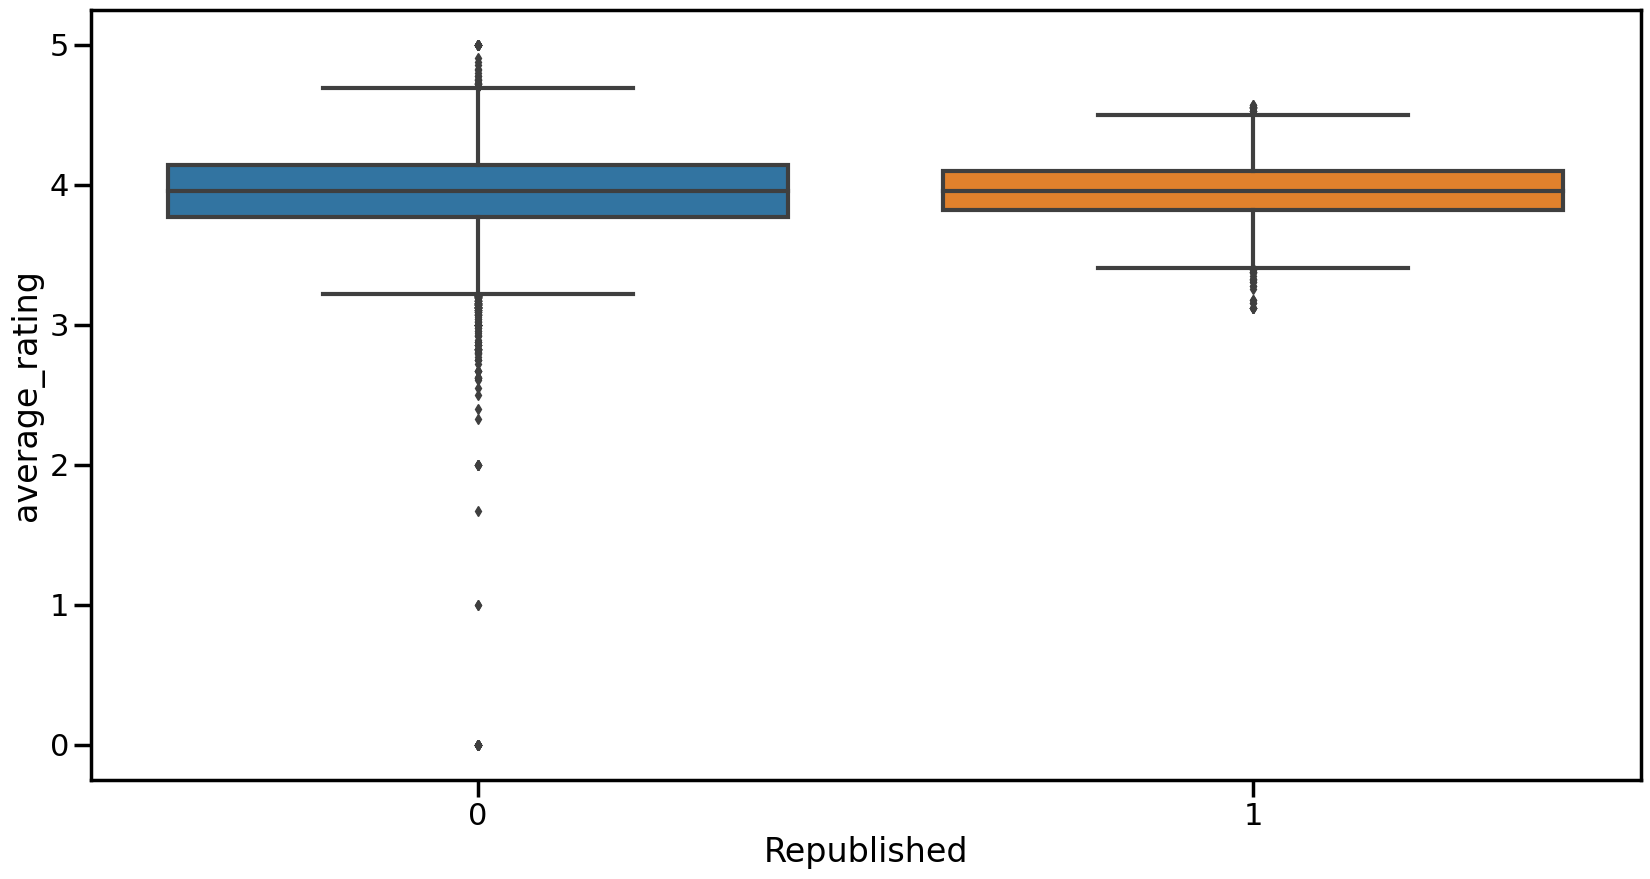

0    9865
1    1262
Name: Republished, dtype: int64

In [214]:
#Finaly we will keep as information if the books has been published more than once and see if it as an impact on the rating
#Lets create one dummy to say if the book has been republished or has more than one occurance

df['Republished'] = np.where(
    df['Occur'] == 1, 0, 1) 


plt.figure(figsize=(20,10))
sns.boxplot(x=df.Republished,y=df.average_rating)
plt.show()


df.Republished.value_counts() 

#We confirm that republished books have a smaller std. The dataset is also unbalanced. 

In [215]:
#At this point we choose to filter out books with less that 100 ratings in total, it will allow us to build a stonger model
#and remove some outliers
#The sum of the ratings count per title 
# This will allow us to then exclude the books with less 100 ratings in total
df['Sum_Ratings_count'] = df.groupby('title')['ratings_count'].transform('sum')
df.drop(df[df['Sum_Ratings_count'] < 100].index, inplace = True)


In [217]:
#We now have 8641 rows
df.describe()

average_rating    num_pages  ratings_count  text_reviews_count  \
count     8641.000000  8641.000000   8.641000e+03         8641.000000   
mean         3.954447   349.399259   2.308697e+04          696.724800   
std          0.265325   240.618926   1.271737e+05         2904.978401   
min          2.400000     0.000000   0.000000e+00            0.000000   
25%          3.790000   208.000000   4.060000e+02           29.000000   
50%          3.970000   310.000000   1.696000e+03           93.000000   
75%          4.140000   424.000000   8.406000e+03          375.000000   
max          4.820000  6576.000000   4.597666e+06        94265.000000   

             Occur  Republished  Sum_Ratings_count  
count  8641.000000  8641.000000       8.641000e+03  
mean      1.305983     0.142345       4.036362e+04  
std       0.979594     0.349423       1.802120e+05  
min       1.000000     0.000000       1.000000e+02  
25%       1.000000     0.000000       5.530000e+02  
50%       1.000000     0.000000       2.538000e+03  
75%       1.000000     0.000000       1.279700e+04  
max       9.000000     1.000000       4.597666e+06

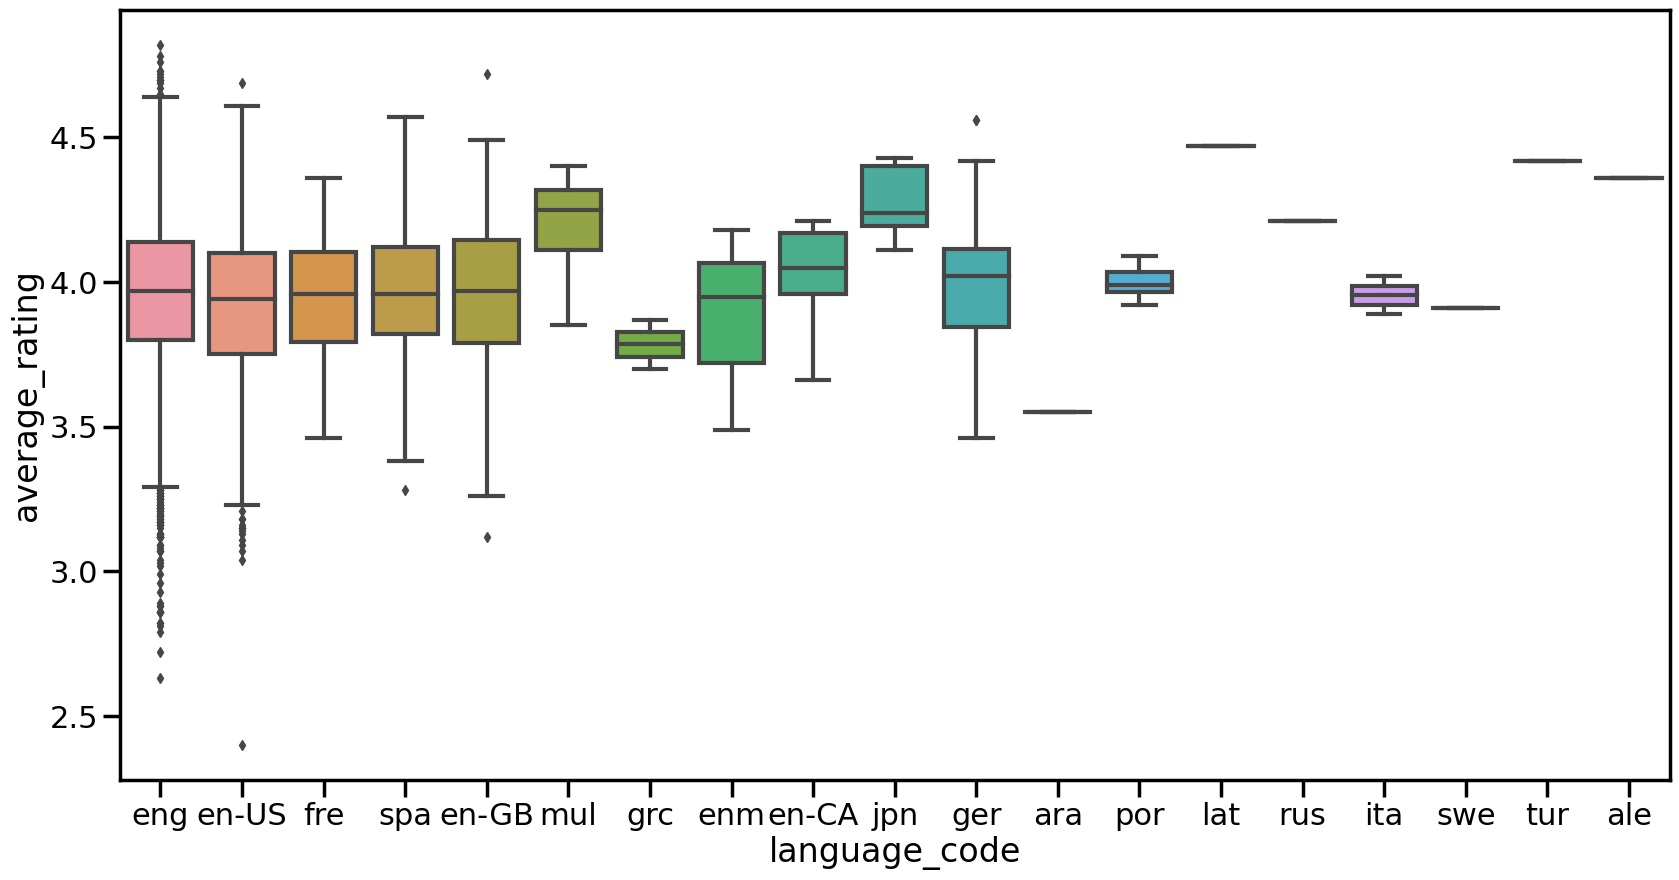

eng      7170
en-US    1115
en-GB     139
spa       104
fre        52
ger        19
jpn         8
en-CA       7
mul         7
por         7
enm         3
grc         2
ita         2
ara         1
lat         1
rus         1
swe         1
tur         1
ale         1
Name: language_code, dtype: int64


language_code
en-CA    4.025714
eng      3.959132
en-GB    3.951151
en-US    3.918323
Name: average_rating, dtype: float64

In [221]:
#After a big thinking we gonna keep only one book title, so we gonna compute the total ratings count; the average num of pages and the average year of publication per book, 
#and delete all the duplicates. But before, we need to check if the language code have an impact on the average rating because
#some books have a version in different languages (ie. Salem's lot)
plt.figure(figsize=(20,10))
sns.boxplot(x=df.language_code,y=df.average_rating)
plt.show()
#First we see that the languages does have an impact on the mean of the aveage ratings but also on its standard deviation

print(df.language_code.value_counts())
# We look at the differents books languages. Most of them are in english. This data is highly unbalanced. 
#Some languages are underrepresented I will only keep the languages with at list 10 books in the first place 
#so we actually can't use this variable 

df.groupby(["language_code"]).mean(numeric_only=True).average_rating.sort_values(ascending=False)

#Because of higly unbalanced data set, we gonna only keep english books, our model will be set for english books

# select all rows in the dataframe that start with 'app'
eng_df = df[df['language_code'].str.startswith(('en-', 'eng'))]
eng_df.groupby(["language_code"]).mean(numeric_only=True).average_rating.sort_values(ascending=False)



In [222]:
eng_df.describe()
#We now have 8431 rows

average_rating    num_pages  ratings_count  text_reviews_count  \
count     8431.000000  8431.000000   8.431000e+03         8431.000000   
mean         3.953659   348.745582   2.347789e+04          710.392480   
std          0.265846   240.611369   1.285815e+05         2938.839028   
min          2.400000     0.000000   0.000000e+00            0.000000   
25%          3.790000   208.000000   4.210000e+02           30.000000   
50%          3.970000   310.000000   1.756000e+03           96.000000   
75%          4.140000   422.000000   8.741000e+03          386.000000   
max          4.820000  6576.000000   4.597666e+06        94265.000000   

             Occur  Republished  Sum_Ratings_count  
count  8431.000000  8431.000000       8.431000e+03  
mean      1.304827     0.140197       4.093385e+04  
std       0.984494     0.347212       1.816028e+05  
min       1.000000     0.000000       1.000000e+02  
25%       1.000000     0.000000       5.760000e+02  
50%       1.000000     0.000000       2.592000e+03  
75%       1.000000     0.000000       1.309500e+04  
max       9.000000     1.000000       4.597666e+06

In [223]:
#Per title transformation :
#Here are the transformation to compute the total ratings count; the average num of pages and the average year of publication per book, 
#and delete all the duplicates.

eng_df['Avg_num_pages'] = eng_df.groupby('title')['num_pages'].transform('mean')
eng_df['Avg_num_pages'] = eng_df['Avg_num_pages'].round(decimals = 0)

#Because the rating is already an average of all the rating for one book, 
#we are keeping only one row per title. We will average the year per title to keep the information (like for num_pages) 
#and then delete the row. 

#Year of first publication :

#first we  extract the year from the column date and convert it to int
eng_df['year'] = eng_df['publication_date'].str.slice(start=-4)
eng_df['year'] = eng_df['year'].astype(int)

#Then keep the year of first publication per book
eng_df['year_of_first_publication'] = eng_df.groupby('title')['year'].transform('min')
eng_df['year_of_first_publication'] = eng_df['year_of_first_publication'].astype(int)

#The sum of the ratings count per title 
# This will allow us to then exclude the books with less 100 ratings in total
eng_df['Sum_Ratings_count'] = eng_df.groupby('title')['ratings_count'].transform('sum')

#Average rating per book's title :
#We note that all the ratings for Salem's lot are not the same, we will compute the average rating per title which we will 
#ponderate per ratings_count 

eng_df['Ponderate_avg_ratings_per_row'] = eng_df["average_rating"]*(eng_df["ratings_count"]/ eng_df["Sum_Ratings_count"])
eng_df['Ponderate_avg_ratings_per_book'] = eng_df.groupby('title')['Ponderate_avg_ratings_per_row'].transform('sum').round(decimals = 2)

#Droping useless column now 
eng_df = eng_df.drop(columns=["Ponderate_avg_ratings_per_row"]) 

#Let's check our new column
#1-Ponderate_avg_ratings_per_book / 2-year_of_first_publication / -3 Sum_Ratings_count / -4 Avg_num_pages

SalemsLot = eng_df.loc[eng_df['title'] == "'Salem's Lot"]
print(SalemsLot.head())

#We can now drop all the duplicate rows

eng_dfunique = eng_df.drop_duplicates(subset=['title'])
print(eng_dfunique.describe(include = ['O']))

eng_dfunique.head()



               title                         authors  average_rating  \
bookID                                                                 
5413    'Salem's Lot  Stephen King/Jerry N. Uelsmann            4.25   
5414    'Salem's Lot        Stephen King/Ron McLarty            4.02   
5415    'Salem's Lot                    Stephen King            4.02   
5419    'Salem's Lot                    Stephen King            4.02   
5420    'Salem's Lot                    Stephen King            4.02   

       language_code  num_pages  ratings_count  text_reviews_count  \
bookID                                                               
5413             eng        594          84123                 571   
5414             eng         17            227                  54   
5415             eng        405           1039                 130   
5419           en-US        427            178                  35   
5420             eng        586             25                   6   

    

C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\3234183552.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df['Avg_num_pages'] = eng_df.groupby('title')['num_pages'].transform('mean')
C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\3234183552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df['Avg_num_pages'] = eng_df['Avg_num_pages'].round(decimals = 0)
C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\3234183552.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                           authors  average_rating language_code  num_pages  \
bookID                                                                        
1       J.K. Rowling/Mary GrandPré            4.57           eng        652   
2       J.K. Rowling/Mary GrandPré            4.49           eng        870   
4                     J.K. Rowling            4.42           eng        352   
5       J.K. Rowling/Mary GrandPré            4.56           eng        435   
8       J.K. Rowling/Mary GrandPré            4.78           eng       2690   

        ratings_count  text_reviews_count publication_date        publisher  \
bookID                                                                        
1             2095690               27591        9/16/2006  Scholastic Inc.   
2             2153167               29221        9/01/2004  Scholastic Inc.   
4                6333                 244       11/01/2003       Scholastic   
5             2339585               36325        5/01/2004  Scholastic Inc.   
8               41428                 164        9/13/2004       Scholastic   

        Occur  Republished  Sum_Ratings_count  Avg_num_pages  year  \
bookID                                                               
1           2            1            2096903          710.0  2006   
2           1            0            2153167          870.0  2004   
4           2            1            2300296          346.0  2003   
5           2            1            2342726          458.0  2004   
8           1            0              41428         2690.0  2004   

        year_of_first_publication  Ponderate_avg_ratings_per_book  
bookID                                                             
1                            2006                            4.57  
2                            2004                            4.49  
4                            1999                            4.42  
5                            2004                            4.56  
8                            2004                            4.78

C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\2531965357.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_dfunique['Title_word_count'] = eng_dfunique['title'].apply(count_words)


<AxesSubplot: xlabel='Title_word_count', ylabel='Ponderate_avg_ratings_per_book'>

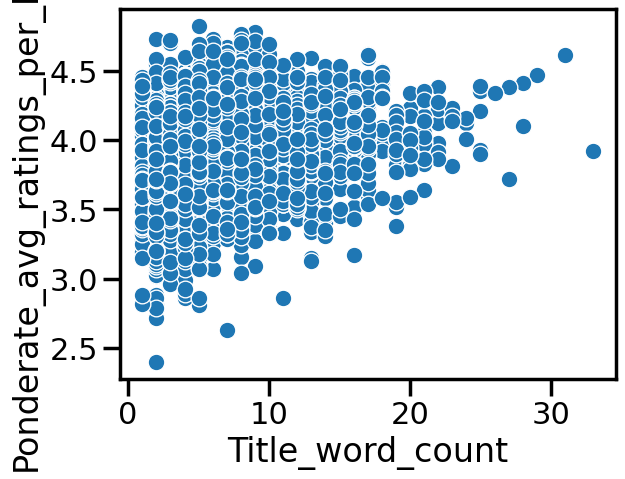

In [252]:
#finally with the title, we want to look if the number of words has an impact on the rating

# Define a function to count words in a string
def count_words(string):
    return len(string.split())

# Apply the function to the 'Bio' column and create a new column with the counts
eng_dfunique['Title_word_count'] = eng_dfunique['title'].apply(count_words)
eng_dfunique.describe()

sns.scatterplot(data=eng_dfunique,x="Title_word_count",y="Ponderate_avg_ratings_per_book")

#We see a small correlation

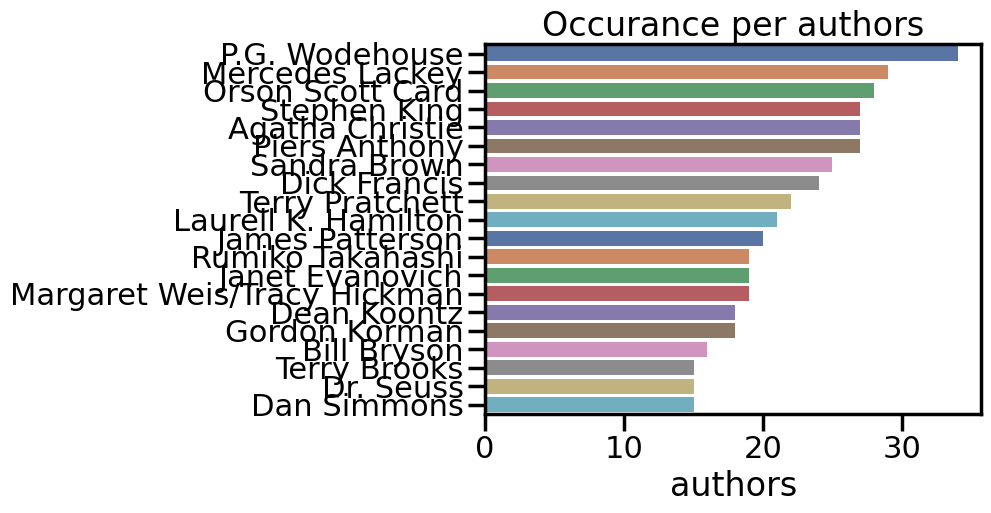

C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\4288656306.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_dfunique['Occur_authors'] = eng_dfunique.groupby('authors')['authors'].transform('size')


<AxesSubplot: xlabel='Occur_authors', ylabel='Ponderate_avg_ratings_per_book'>

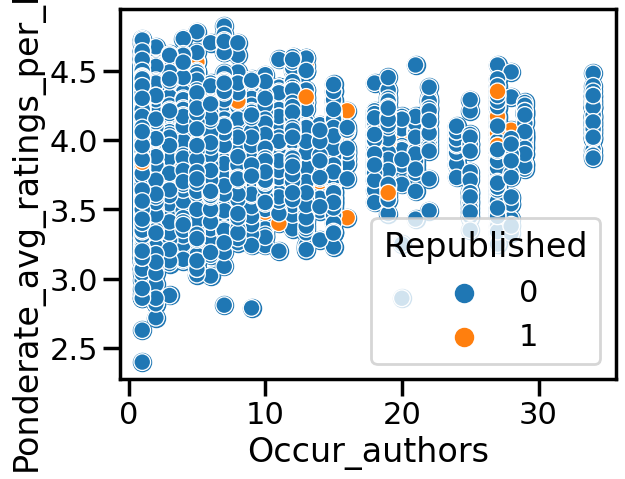

In [234]:
#2) find a way to look if the number of books written by an authors is correlated with the average rating of his books 

#Here are the most famus authors
authors = eng_dfunique['authors'].value_counts()[:20]
sns.barplot(x=authors, y=authors.index, palette= 'deep').set(title='Occurance per authors')
plt.show()


#New column with the occurance of an author
eng_dfunique['Occur_authors'] = eng_dfunique.groupby('authors')['authors'].transform('size')


sns.scatterplot(data=eng_dfunique,x="Occur_authors",y="Ponderate_avg_ratings_per_book",hue= "Republished")

#We see that the min rating gets higher for a higher number of occurances but the relation is not strong.

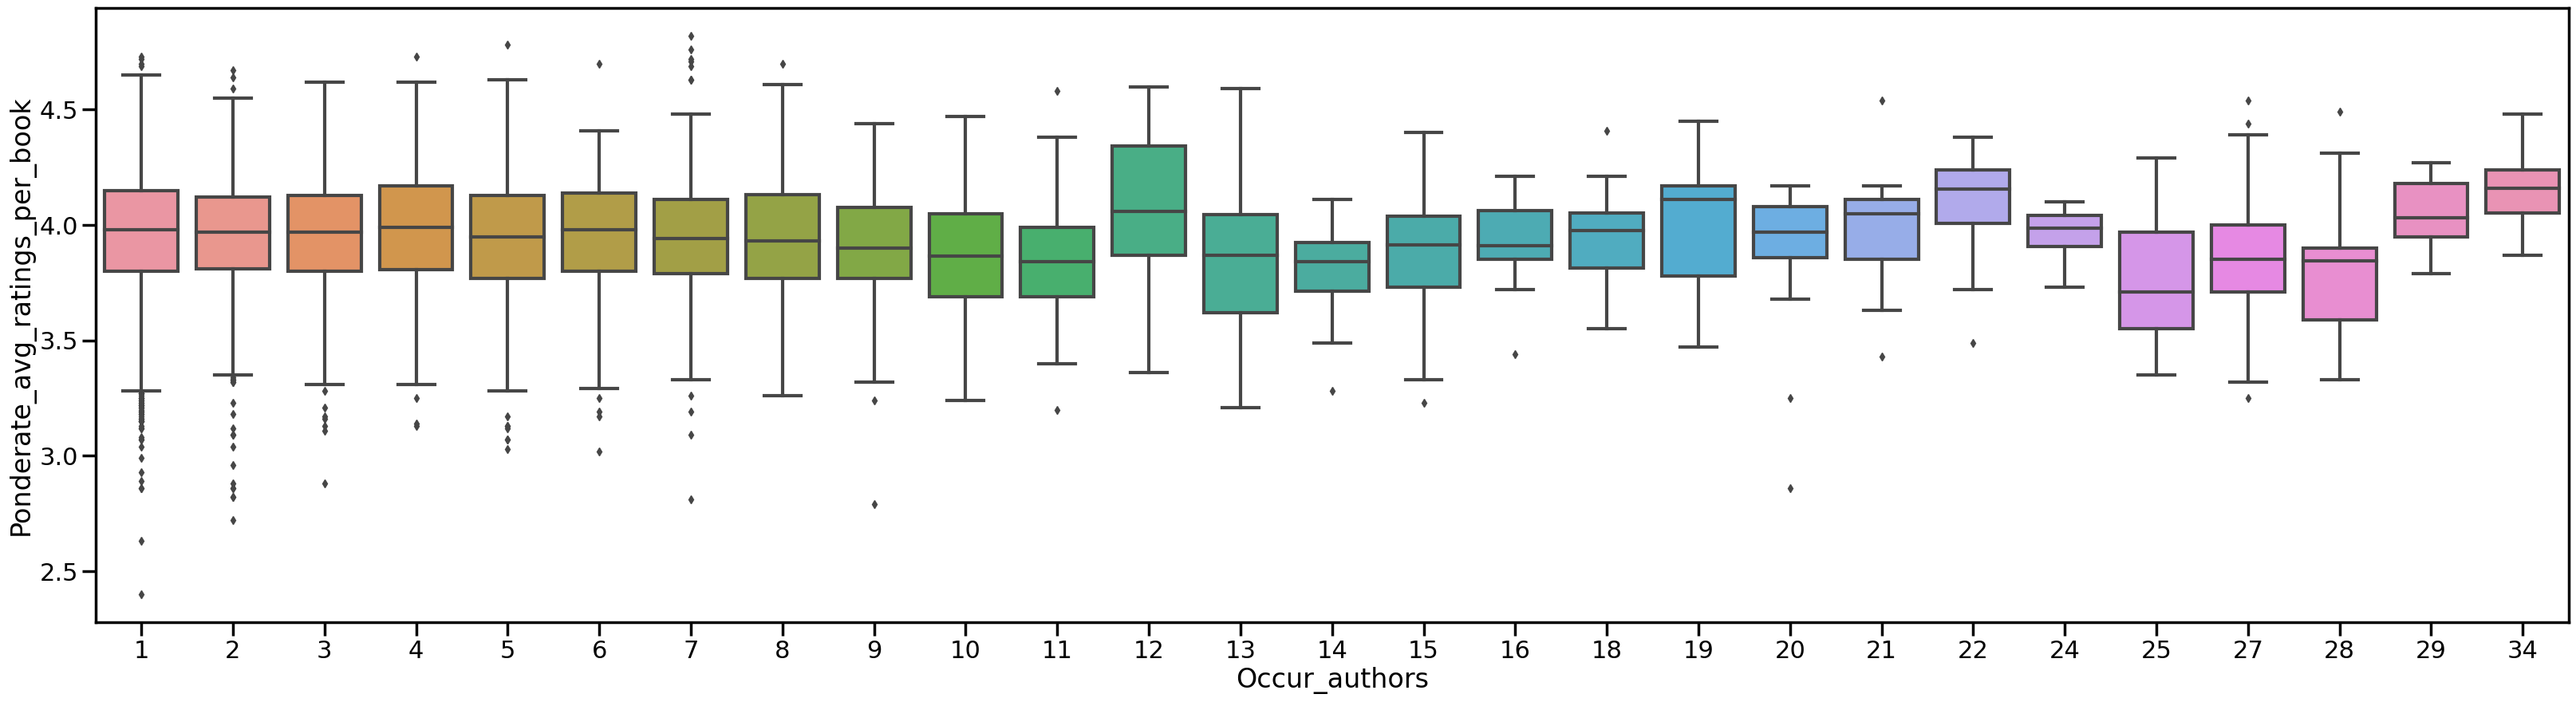

average_rating    num_pages  ratings_count  text_reviews_count  \
count     4224.000000  4224.000000   4.224000e+03         4224.000000   
mean         3.944257   358.099669   2.847354e+04          846.228456   
std          0.267458   238.794793   1.318508e+05         2814.045997   
min          2.720000     0.000000   1.900000e+01            0.000000   
25%          3.780000   224.000000   8.225000e+02           44.000000   
50%          3.960000   320.000000   3.175000e+03          155.000000   
75%          4.120000   425.000000   1.413225e+04          564.250000   
max          4.820000  6576.000000   2.530894e+06        56604.000000   

             Occur  Republished  Sum_Ratings_count  Avg_num_pages        year  \
count  4224.000000  4224.000000       4.224000e+03    4224.000000  4224.00000   
mean      1.081439     0.056345       3.105618e+04     357.862689  2000.77983   
std       0.418036     0.230613       1.419009e+05     238.294497     6.89348   
min       1.000000     0.000000       1.010000e+02       0.000000  1940.00000   
25%       1.000000     0.000000       8.755000e+02     224.000000  1998.00000   
50%       1.000000     0.000000       3.422500e+03     320.000000  2003.00000   
75%       1.000000     0.000000       1.534875e+04     425.000000  2005.00000   
max       9.000000     1.000000       2.530894e+06    6576.000000  2020.00000   

       year_of_first_publication  Ponderate_avg_ratings_per_book  \
count                4224.000000                     4224.000000   
mean                 2000.573864                        3.944342   
std                     7.098958                        0.267150   
min                  1940.000000                        2.720000   
25%                  1998.000000                        3.780000   
50%                  2003.000000                        3.960000   
75%                  2005.000000                        4.120000   
max                  2020.000000                        4.820000   

       Occur_authors  Num_authors  
count    4224.000000  4224.000000  
mean        7.373106     1.185369  
std         6.497016     0.462636  
min         2.000000     1.000000  
25%         3.000000     1.000000  
50%         5.000000     1.000000  
75%         9.000000     1.000000  
max        34.000000     6.000000

In [236]:
#Lets look at the subdataset of authors who wrote more than one book

FamousWritter = eng_dfunique[eng_dfunique.duplicated(subset=['authors'],keep=False)]


FamousWritter.sort_values(by='Occur_authors', ascending=False) 
#df.describe()
plt.figure(figsize=(40,10))
sns.boxplot(x=eng_dfunique.Occur_authors,y=eng_dfunique.Ponderate_avg_ratings_per_book)
plt.show()
FamousWritter.describe()

#not very significative

C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\3559807942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_dfunique['Num_authors'] = eng_dfunique['authors'].str.count('/') +1


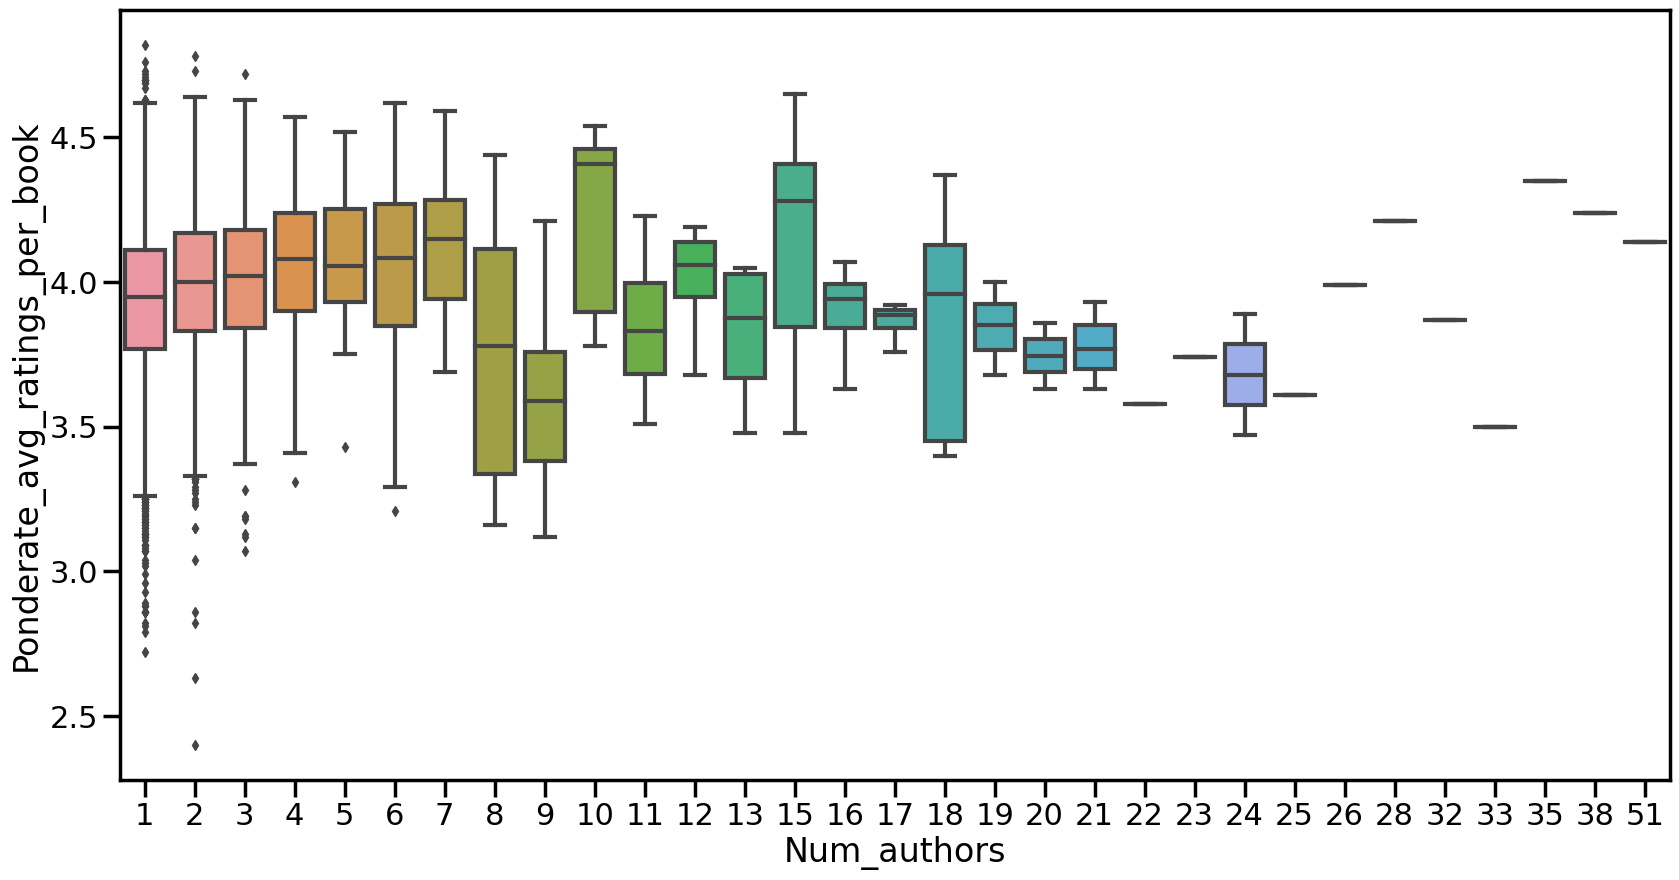

title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                           authors  average_rating language_code  num_pages  \
bookID                                                                        
1       J.K. Rowling/Mary GrandPré            4.57           eng        652   
2       J.K. Rowling/Mary GrandPré            4.49           eng        870   
4                     J.K. Rowling            4.42           eng        352   
5       J.K. Rowling/Mary GrandPré            4.56           eng        435   
8       J.K. Rowling/Mary GrandPré            4.78           eng       2690   

        ratings_count  text_reviews_count publication_date        publisher  \
bookID                                                                        
1             2095690               27591        9/16/2006  Scholastic Inc.   
2             2153167               29221        9/01/2004  Scholastic Inc.   
4                6333                 244       11/01/2003       Scholastic   
5             2339585               36325        5/01/2004  Scholastic Inc.   
8               41428                 164        9/13/2004       Scholastic   

        Occur  Republished  Sum_Ratings_count  Avg_num_pages  year  \
bookID                                                               
1           2            1            2096903          710.0  2006   
2           1            0            2153167          870.0  2004   
4           2            1            2300296          346.0  2003   
5           2            1            2342726          458.0  2004   
8           1            0              41428         2690.0  2004   

        year_of_first_publication  Ponderate_avg_ratings_per_book  \
bookID                                                              
1                            2006                            4.57   
2                            2004                            4.49   
4                            1999                            4.42   
5                            2004                            4.56   
8                            2004                            4.78   

        Occur_authors  Num_authors Co_Writing_categories  
bookID                                                    
1                   5            2           Two authors  
2                   5            2           Two authors  
4                   4            1        Single authors  
5                   5            2           Two authors  
8                   5            2           Two authors

In [241]:
#3) Find a way to count the number of authors of the book --> Count the number of "/" +1 = number of authors

eng_dfunique['Num_authors'] = eng_dfunique['authors'].str.count('/') +1
eng_dfunique.describe()


plt.figure(figsize=(20,10))
sns.boxplot(x=eng_dfunique.Num_authors,y=eng_dfunique.Ponderate_avg_ratings_per_book)
plt.show()
#We see that up to 7 authors the mean of average rating seems to rise and then the relation seems to reverse. 
#The number of books in each categories must be very low for many categories
eng_dfunique.Num_authors.value_counts() 
#We will create 3 categories : 1 authors, 2 authors, 3 or more authors


C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\1860896573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_dfunique['Co_Writing_categories'] = np.where(


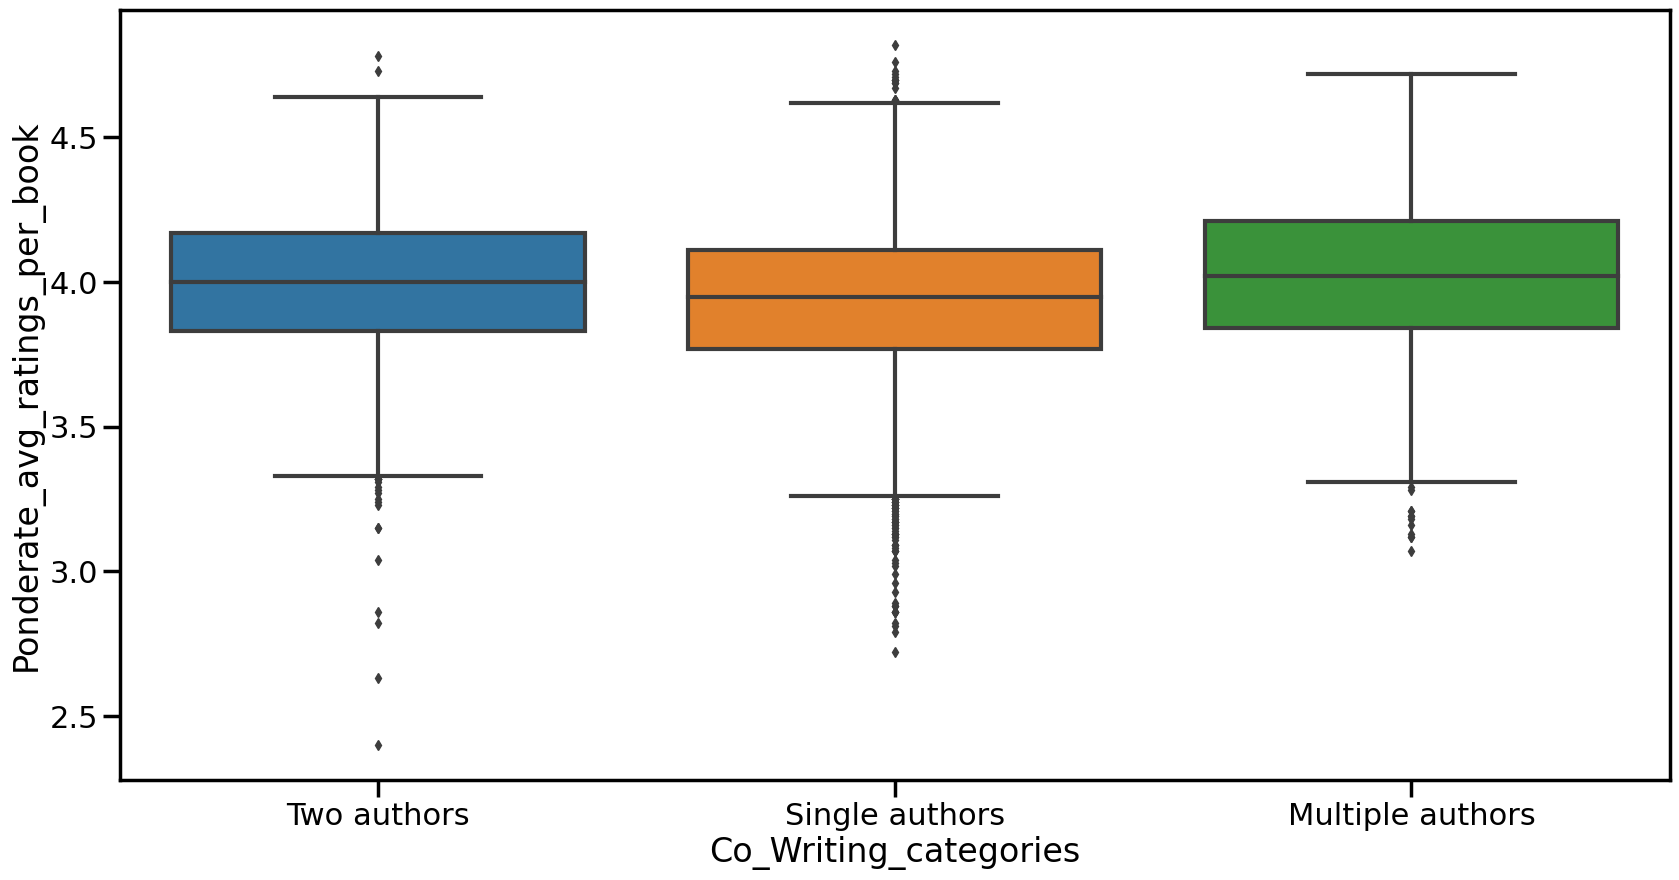

Co_Writing_categories
Multiple authors    4.015492
Two authors         3.989134
Single authors      3.929217
Name: Ponderate_avg_ratings_per_book, dtype: float64

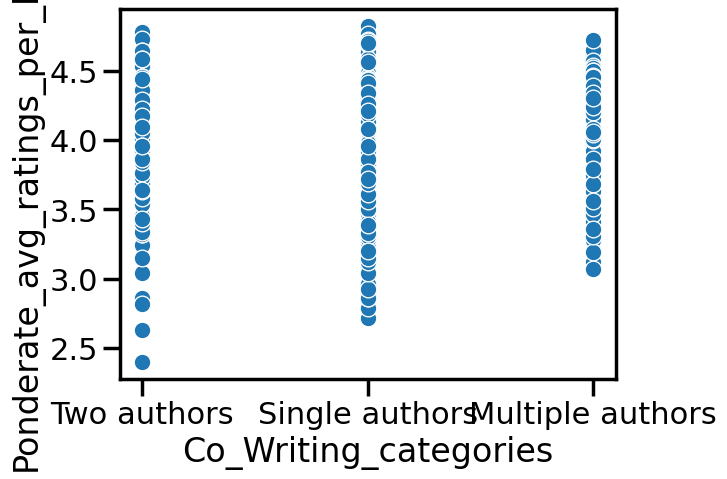

In [242]:
eng_dfunique['Co_Writing_categories'] = np.where(
    eng_dfunique['Num_authors'] == 1, 'Single authors', np.where(
    eng_dfunique['Num_authors'] == 2, 'Two authors', 'Multiple authors')) 


plt.figure(figsize=(20,10))
sns.boxplot(x=eng_dfunique.Co_Writing_categories,y=eng_dfunique.Ponderate_avg_ratings_per_book)
plt.show()

sns.scatterplot(data=eng_dfunique,x="Co_Writing_categories",y="Ponderate_avg_ratings_per_book")
eng_dfunique.Co_Writing_categories.value_counts() 
eng_dfunique.groupby(["Co_Writing_categories"]).mean(numeric_only=True).Ponderate_avg_ratings_per_book.sort_values(ascending=False)

#We don't see any significative impact on the average rating

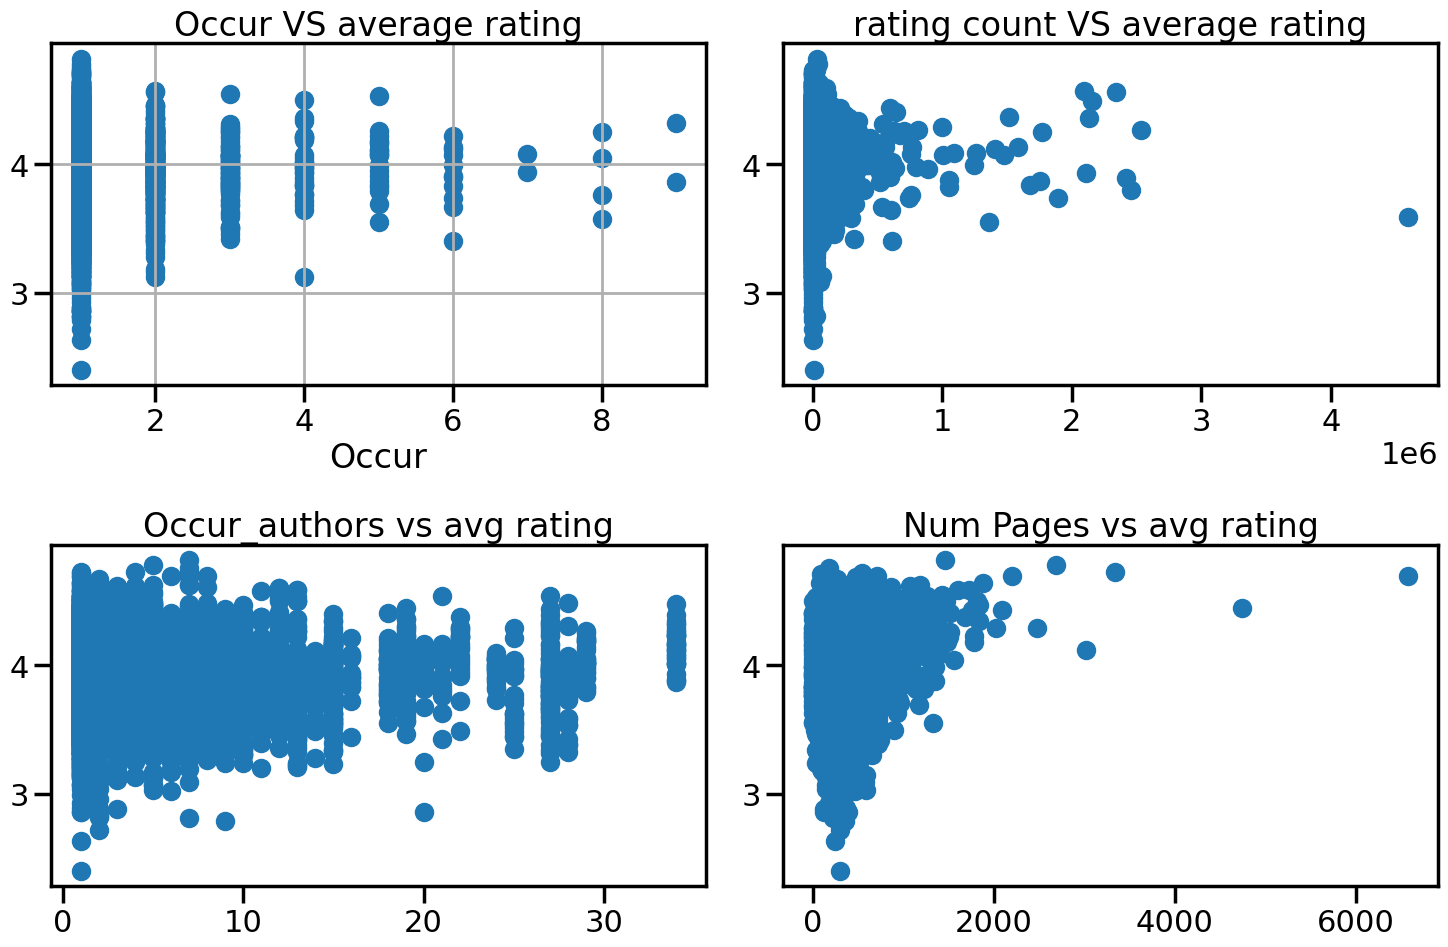

In [243]:
#Look at the correlation 
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
ax1.scatter(eng_dfunique.loc[:, 'Occur'],eng_dfunique["Ponderate_avg_ratings_per_book"])
ax1.set_title("Occur VS average rating")
ax1.set_xlabel("Occur")
ax1.grid()

ax2.scatter(eng_dfunique.loc[:,'ratings_count'],eng_dfunique.loc[:,'Ponderate_avg_ratings_per_book'])
ax2.set_title("rating count VS average rating")
ax3.scatter(eng_dfunique.loc[:, 'Occur_authors'], eng_dfunique.loc[:,'Ponderate_avg_ratings_per_book'])
ax3.set_title("Occur_authors vs avg rating")
ax4.scatter(eng_dfunique.loc[:, 'num_pages'], eng_dfunique.loc[:,'Ponderate_avg_ratings_per_book'])
ax4.set_title("Num Pages vs avg rating")
#)
fig.tight_layout()
plt.show()


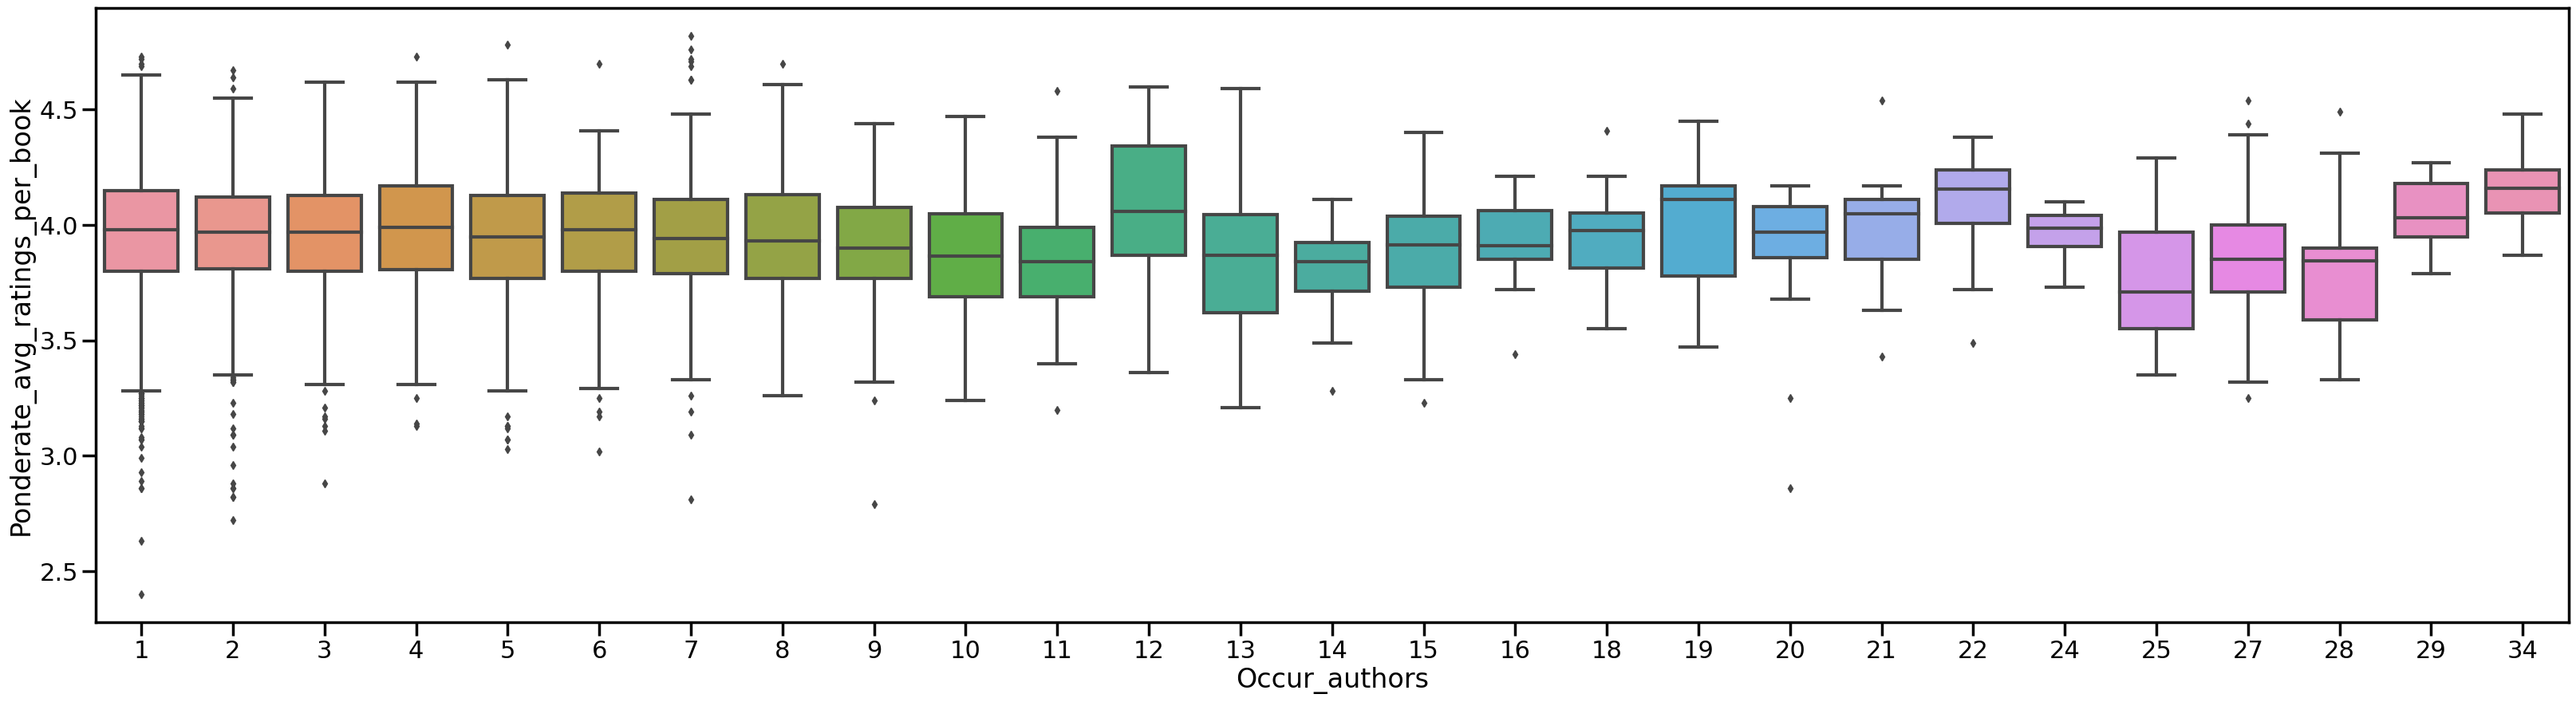

In [247]:
#Lets look at the subdataset of authors who wrote more than one book

FamousWritter = eng_dfunique[eng_dfunique.duplicated(subset=['authors'],keep=False)]


FamousWritter.sort_values(by='Occur_authors', ascending=False) 
FamousWritter.describe()
#df.describe()
plt.figure(figsize=(40,10))
sns.boxplot(x=eng_dfunique.Occur_authors,y=eng_dfunique.Ponderate_avg_ratings_per_book)
plt.show()
#not very significative

In [246]:
eng_dfunique.publisher.value_counts()#Some publisher have a lto of books, some other only one --> Create a categorisation with the size ?

Vintage                291
Penguin Books          213
Penguin Classics       140
Mariner Books          132
Ballantine Books       129
                      ... 
Celestial Arts           1
Pinter & Martin Ltd      1
Abstract Studio          1
Totem Books              1
Listening Library        1
Name: publisher, Length: 1419, dtype: int64

In [26]:
#plt.boxplot(df.publisher.value_counts().values)
#Report_Card.loc[:,"Grades"]


type(df.iloc[:,1])
#plt.boxplot(df.ratings_count.values) #

#.scatter(df["bookID"],df["ratings_count"])

pandas.core.series.Series

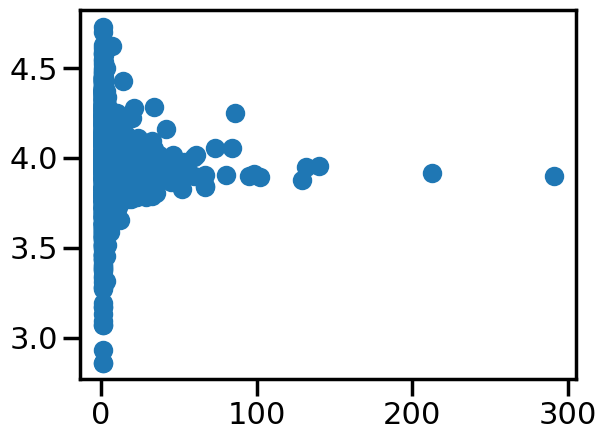

In [248]:
#creating a data frame with the number of book and the average rating per publisher to look for a correlation
publicount = pd.DataFrame(eng_dfunique.publisher.value_counts().values, index = eng_dfunique.publisher.value_counts().index )
publicount.rename(columns={ publicount.columns[0]: "BooksCount_Per_Publisher" }, inplace = True)
publicount = publicount.sort_index()

#Need to add this array to the previous data frame
publirating = pd.DataFrame(eng_dfunique.groupby(["publisher"]).mean(numeric_only=True).Ponderate_avg_ratings_per_book.values,eng_dfunique.groupby(["publisher"]).mean(numeric_only=True).Ponderate_avg_ratings_per_book.index)
publirating.rename(columns={ publirating.columns[0]: "Avg_ratings_Per_Publisher" }, inplace = True)

publicountrating = pd.DataFrame(publicount.loc[:,'BooksCount_Per_Publisher'], publicount.index)
publicountrating['Avg_ratings_Per_Publisher'] = publirating



publicount.describe() # we can see there is huge outliers, some publisher have a lots of books in the data set, there is a big std. We can see than 75% of 
#the publishers have 3 books or less in the data set. We will categorise those data between big and small publisher ? 
#We could as well look if the publisher already published a good book and use this as a dummy variable.

publirating.describe() # We could wonder if the size of the publisher has a link with the quality of the books they published.
#correlation between averageratings and numbers of books published.
publicount.head()
publirating.head()
publicountrating.head()
plt.scatter(publicountrating.loc[:, 'BooksCount_Per_Publisher'],publicountrating["Avg_ratings_Per_Publisher"])

#We don't see any pattern here

C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\3137039951.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(eng_dfunique.year)


<AxesSubplot: xlabel='year', ylabel='Density'>

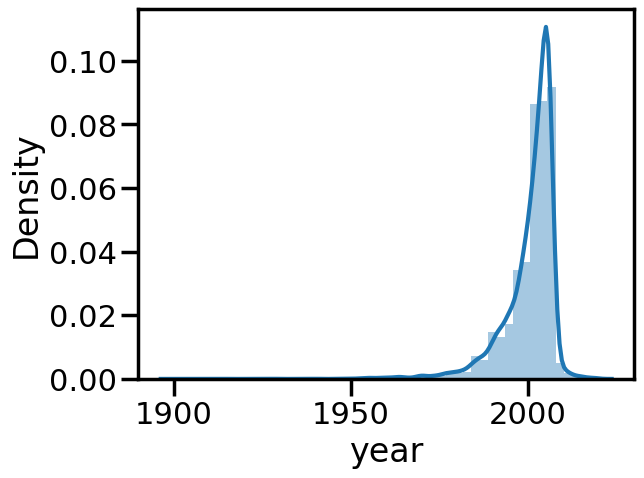

In [253]:
#6) Analyse the year from the column date and convert


sns.distplot(eng_dfunique.year)


<AxesSubplot: xlabel='year', ylabel='Ponderate_avg_ratings_per_book'>

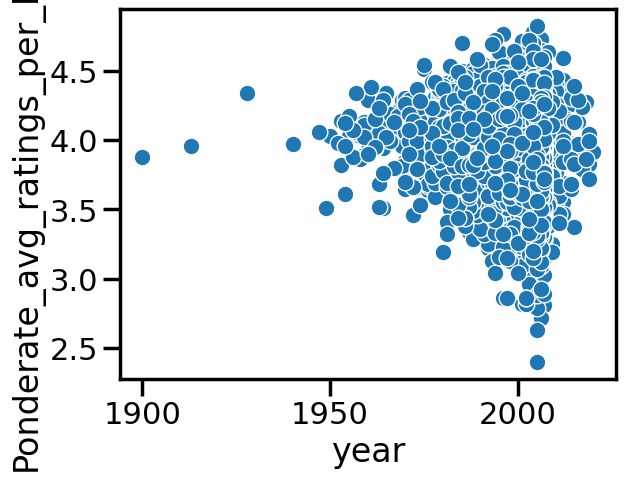

In [254]:
sns.scatterplot(data=eng_dfunique,x="year",y="Ponderate_avg_ratings_per_book")
#we see a light negative correlation but again the data set is not great, should we errase the outliers ? 

In [283]:
#Final dataframe for our model

eng_dfunique.head()


# select columns 'name' and 'age' to create a subdataframe
final_df = eng_dfunique[['Ponderate_avg_ratings_per_book','Republished','Avg_num_pages', 'year_of_first_publication', 'Title_word_count']]

final_df.describe()
#We have 7710 rows

Ponderate_avg_ratings_per_book  Republished  Avg_num_pages  \
count                     7710.000000  7710.000000    7710.000000   
mean                         3.954342     0.059792     345.662127   
std                          0.267482     0.237117     235.679783   
min                          2.400000     0.000000       0.000000   
25%                          3.790000     0.000000     208.000000   
50%                          3.970000     0.000000     307.000000   
75%                          4.140000     0.000000     416.000000   
max                          4.820000     1.000000    6576.000000   

       year_of_first_publication  Title_word_count  
count                7710.000000       7710.000000  
mean                 2000.314137          5.955253  
std                     7.882826          3.806065  
min                  1900.000000          1.000000  
25%                  1998.000000          3.000000  
50%                  2003.000000          5.000000  
75%                  2005.000000          8.000000  
max                  2020.000000         33.000000

In [284]:
final_df.head()


Ponderate_avg_ratings_per_book  Republished  Avg_num_pages  \
bookID                                                               
1                                 4.57            1          710.0   
2                                 4.49            0          870.0   
4                                 4.42            1          346.0   
5                                 4.56            1          458.0   
8                                 4.78            0         2690.0   

        year_of_first_publication  Title_word_count  
bookID                                               
1                            2006                 9  
2                            2004                11  
4                            1999                10  
5                            2004                10  
8                            2004                 9

R^2 Score: -0.05139408298422077
MSE: 0.07772264742864494
MAE: 0.21461371132200424


C:\Users\Ben\AppData\Local\Temp\ipykernel_20064\1282663601.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


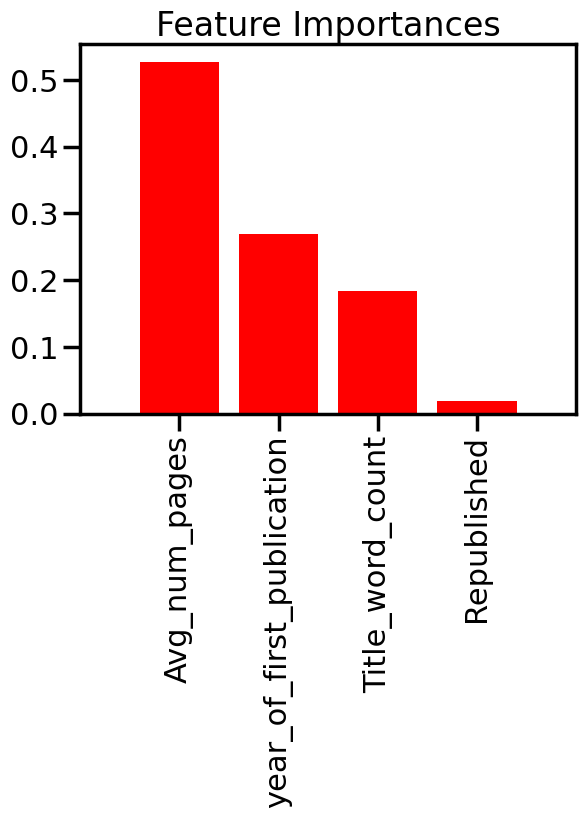

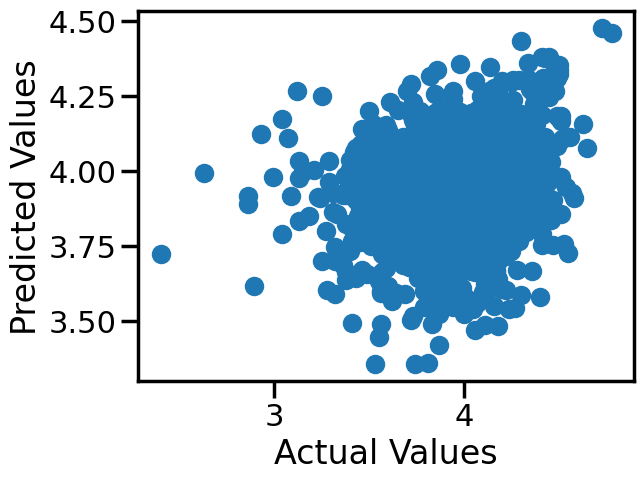

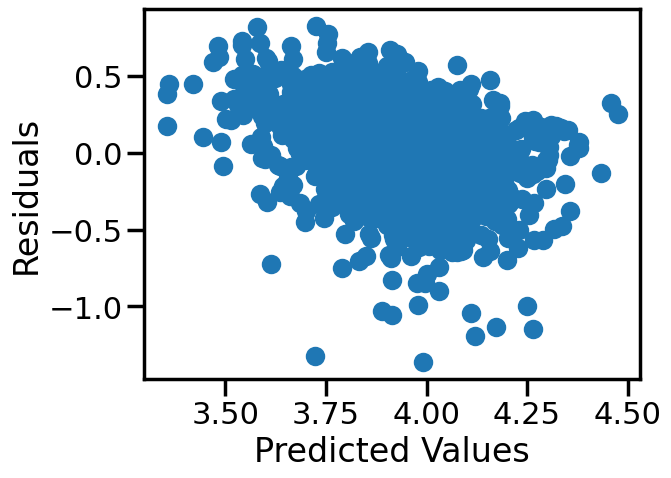

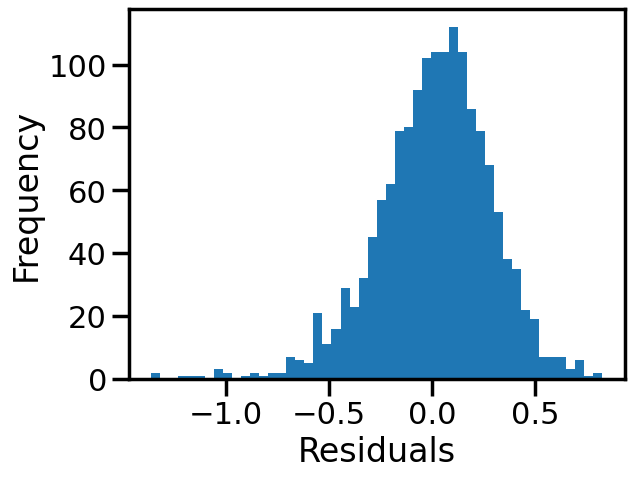

In [285]:
# model 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('Ponderate_avg_ratings_per_book', axis=1), final_df['Ponderate_avg_ratings_per_book'], test_size=0.2)

# Create a random forest classifier with 100 trees
rf = RandomForestRegressor(n_estimators=100)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test)

# Calculate the R^2 score of the model on the test data
r2score = r2_score(y_test, y_pred)

print('R^2 Score:', r2score)

# Calculate the mean squared error of the model on the test data
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

# Calculate the mean absolute error of the model on the test data
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

# Get the feature importances of the model
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()


# Plot the predicted vs actual values
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot the residuals
plt.figure()
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Plot a histogram of the residuals
plt.figure()
plt.hist(y_test - y_pred, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Linear Regression R^2 Score: 0.08636963479999582
Linear Regression MSE: 0.06753868212097382
Linear Regression MAE: 0.20025322926200426

Linear Regression Coefficients:
                            Coefficient
Republished                  -0.007063
Avg_num_pages                 0.000213
year_of_first_publication    -0.002464
Title_word_count              0.013024


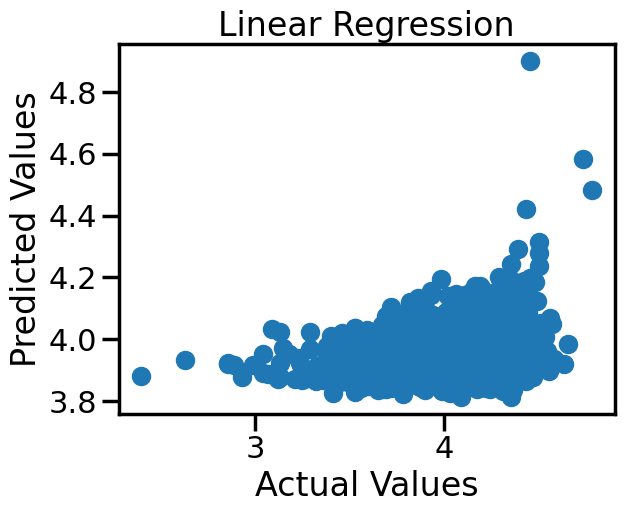

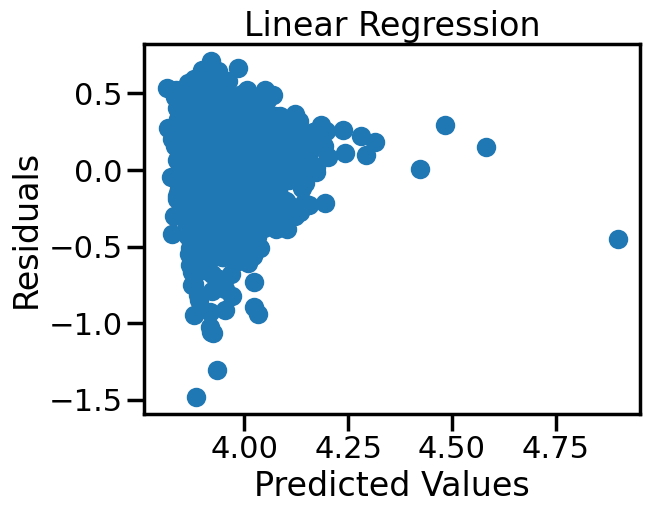

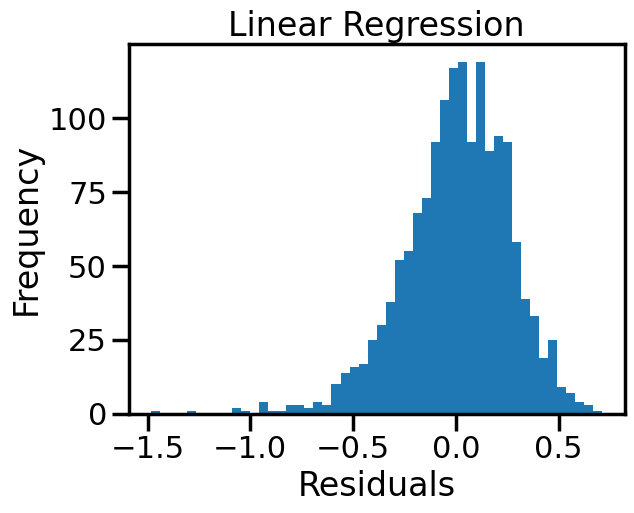

In [289]:

# Fit a linear regression model on the training data
lr = LinearRegression()
lr.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred_lr = lr.predict(X_test)

# Calculate the R^2 score of the model on the test data
r2score_lr = r2_score(y_test, y_pred_lr)
print('Linear Regression R^2 Score:', r2score_lr)

# Calculate the mean squared error of the model on the test data
mse_lr = mean_squared_error(y_test, y_pred_lr)
print('Linear Regression MSE:', mse_lr)

# Calculate the mean absolute error of the model on the test data
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('Linear Regression MAE:', mae_lr)

# Get the coefficients of the linear regression model
coefficients = pd.DataFrame(lr.coef_, index=X_train.columns, columns=['Coefficient'])
print('\nLinear Regression Coefficients:\n', coefficients)

# Plot the predicted vs actual values for the linear regression model
plt.figure()
plt.scatter(y_test, y_pred_lr)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')
plt.show()

# Plot the residuals for the linear regression model
plt.figure()
plt.scatter(y_pred_lr, y_test - y_pred_lr)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linear Regression')
plt.show()

# Plot a histogram of the residuals for the linear regression model
plt.figure()
plt.hist(y_test - y_pred_lr, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Linear Regression')
plt.show()